# Preparation

In [4]:
pip freeze > requirements.txt

In [1]:
!pip install arch
!pip install yfinance
!pip install scikit-optimize
!pip install sigopt

     |████████████████████████████████| 902 kB 10.0 MB/s 
     |████████████████████████████████| 9.8 MB 35.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 6.4 MB 16.4 MB/s 
     |████████████████████████████████| 62 kB 717 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.graph_objects as go
import math as m
from scipy import stats
import seaborn as sns
from itertools import combinations
from arch import arch_model
import yfinance as yf

# from IPython.display import display, Latex
from statsmodels.stats import diagnostic
import statsmodels.api as sm

#Machine Learning
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.svm import NuSVR
# import statsmodels.stats.diagnostic
  
def calculate_aic(n, mse, num_params):
	  aic = n * m.log(mse) + 2 * num_params
	  return aic

def calculate_bic(n, mse, num_params):
	  bic = n * m.log(mse) + num_params * m.log(n)
	  return bic

def stat_desc(y_pred):
    print('Skewness {}'.format(stats.skew(y_pred)))
    print('Kurtosis {}'.format(stats.kurtosis(y_pred)))
    print('Mean {}'.format(y_pred.mean()))
    print('STD {}'.format(y_pred.std()))

def data_prep(data):
  data.reset_index(inplace=True)
  data['Date'] = pd.to_datetime(data['Date'])
  #Return
  index = list(range(0, len(data)))
  data['index_dummy'] = index
  data.set_index("index_dummy", inplace = True)

  data['Return'] = 0.0
  for i in range (len(data['Close'])-1):
    data['Return'][i]=m.log(data['Close'][i+1]/data['Close'][i])*100

  data = data.iloc[:-1]
  data['Return']=data['Return'] #di cek lagi

  print('Statistika Deskriptif')
  print(stat_desc(data['Return']))
  print((data["Return"]).describe())

  # #Volatility
  # vol = []
  # data['Volatility'] = 0

  # #new volatility
  # for i in range(len(data)): #salah rumus 
  #   s = 0
  #   if i <m.floor(len(data)/5):
  #     for j in range (5):
  #       s +=(data['Return'][5*i+j])**2
  #       vol.append(s/5)
  #   else:
  #     break

  # count = 0
  # while len(data)> len(vol):
  #   vol.append(0)
  #   count+=1

  # data['Volatility'] = vol
  
  # if count !=0:
  #   data=data.iloc[:-count]

  return (data)

def garch_df(df_sg,p,q): #make data frame base on GARCH(p,q)
  # df_sg = pd.DataFrame(u2)
  # df_sg.rename(columns={'Return':'u2'},inplace=True)
  # df_sg['vol_prox']=(df['Return'].iloc[:-1]-df['Return'].iloc[:-1].mean())**2

  if p>q:
    #return
    for i in range(1,p):
      df_sg['u2_shift'+str(i)] =  df_sg['u2'].shift(-i)

    #volatility
    diff = p-q
    for i in range(p,diff-1,-1):
      df_sg['vol_prox_shift'+str(i)]= df_sg['vol_prox'].shift(-i)

  elif p<q:
    #return
    diff = q-p
    for i in range(q-1,diff-1,-1):
      df_sg['u2_shift'+str(i)] =  df_sg['u2'].shift(-i)

    #volatility
    for i in range(q,0,-1):
      df_sg['vol_prox_shift'+str(i)]= df_sg['vol_prox'].shift(-i)
      
  else:
    #return
    for i in range(1,p):
      df_sg['u2_shift'+str(i)] =  df_sg['u2'].shift(-i)
    #volatility
    for i in range(1,q+1):
      df_sg['vol_prox_shift'+str(i)]= df_sg['vol_prox'].shift(-i)  

  df_sg = df_sg.iloc[:-max(p,q)]
  df_sg = df_sg[sorted(df_sg.columns)]

  if p<q:
    selected_col = df_sg[sorted(df_sg.columns)].iloc[:,:p+1].iloc[:,-p:].columns #select return
    selected_col= selected_col.append(df_sg[sorted(df_sg.columns)].iloc[:,-q-1:-1].columns) #select volatility
  else:
    selected_col = df_sg[sorted(df_sg.columns)].iloc[:,:p].iloc[:,-p:].columns #select return
    selected_col= selected_col.append(df_sg[sorted(df_sg.columns)].iloc[:,-q-1:-1].columns) #select volatility

  
  n_test = m.floor(len(df_sg)/4)
  # print('n_test: ',n_test)
  X_sg = df_sg[selected_col].iloc[:-n_test]
  y_sg = df_sg[df_sg.iloc[:,-1:].columns].iloc[:-n_test]
  X_sg_val = df_sg[selected_col].iloc[-n_test:]
  y_sg_val = df_sg[df_sg.iloc[:,-1:].columns].iloc[-n_test:]

  return X_sg,y_sg,X_sg_val,y_sg_val

def jb_test(data,alpha):
  jb_stat, jb_pval  = stats.jarque_bera(data)
  print('Jarque-Bera Test')
  print('H0: Goodness of fit of the sample data for normality distribution \n')
  if jb_pval <alpha:
    print('JB Stat Test: {}'.format(jb_stat))
    print('JB P-val: {}'.format(jb_pval))
    print('H0 ditolak, sehingga data tidak berdistribusi normal.')
    print('Dengan begitu data terindikasi memiliki distribusi ekor tebal')
  else:
    print('JB Stat Test: {}'.format(jb_stat))
    print('JB P-val: {}'.format(jb_pval))
    print('H0 tidak ditolak, sehingga data berdistribusi normal')

def ljbox(resid,alpha):
  df_lj =sm.stats.acorr_ljungbox(np.array(np.sqrt(resid.residual_variance.iloc[-1:])).flatten(), lags=[2], return_df=True)
  stat_test = df_lj.iloc[0][0]
  p_val = df_lj.iloc[0][1]
  print('Ljung-Box Test')
  print('H0: Absense of autocorrelation \n')
  if p_val <alpha:
    print('LB Stat Test: {}'.format(stat_test))
    print('LB P-val: {}'.format(p_val))
    print('H0 ditolak, sehingga data memiliki autocorelasi.')
  else:
    print('LB Stat Test: {}'.format(stat_test))
    print('LB P-val: {}'.format(p_val))
    print('H0 tidak ditolak, sehingga data tidak memiliki autocorelasi')


def normal_plot(data):
  # fig, ax = plt.subplots()
  mu = data.mean()
  variance = data.var()
  sigma = np.sqrt(variance)
  x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
  plt.plot(x, stats.norm.pdf(x, mu, sigma),label='Normal Curve')
  plt.hist(data,bins=100,label='Return Prediction')
  plt.legend()
  plt.title('Return Distribution Plot')
  plt.show()

def arch_test(resid,alpha):
  arch_test = diagnostic.het_arch(np.array(resid.residual_variance.iloc[-1:]).flatten(),nlags=3)
  f_stat = arch_test[0]
  f_pval = arch_test[1]
  print('\nARCH Test')
  print('H0: a_0 = a_1 = ... = a_n = 0 \n')
  if f_pval <alpha:
    print('ARCH Stat Test: {}'.format(f_stat))
    print('ARCH P-val: {}'.format(f_pval))
    print('H0 ditolak, sehingga arch model dapat digunakan')
  else:
    print('ARCH Stat Test: {}'.format(f_stat))
    print('ARCH P-val: {}'.format(f_pval))
    print('H0 tidak ditolak, sehingga arch model tidak dapat digunakan')
  
def vol_return(data):
  np.random.seed(30)
  # rng = np.random.normal(0,1,len(data))
  rng = np.random.standard_t(3,len(data))
  return np.sqrt(abs(data))*rng

def pred_resid(rt,mean_pred,volatility):
  return (rt-mean_pred)/np.sqrt(abs(volatility))

def interactive_plot(df,data_frame,y_sg_val,y_pred_vol):

  n_test = m.floor(len(data_frame)/2)
  df_vol_pred = pd.DataFrame(df['Date'].iloc[-n_test+1:])
  df_vol_pred['vol_pred']=y_pred_vol
  df_vol_pred['vol_true']=y_sg_val.iloc[:,0]
  df_vol_pred.dropna(inplace=True)

  # Create figure
  fig = go.Figure()
  fig.add_trace(
      go.Scatter(x=list(df_vol_pred.Date), y=list(df_vol_pred.vol_true),name='True'))
  fig.add_trace(
      go.Scatter(x=list(df_vol_pred.Date), y=list(df_vol_pred.vol_pred),name='Prediction',line=dict(dash='dash')))



  # Set title
  fig.update_layout(
      title_text="Time series with range slider and selectors"
  )

  # Add range slider
  fig.update_layout(
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  dict(count=3,
                      label="3m",
                      step="month",
                      stepmode="backward"),
                  dict(count=6,
                      label="6m",
                      step="month",
                      stepmode="backward"),
                  # dict(count=1,
                  #      label="YTD",
                  #      step="year",
                  #      stepmode="todate"),
                  # dict(count=1,
                  #      label="1y",
                  #      step="year",
                  #      stepmode="backward"),
                  dict(step="all")
              ])
          ),
          rangeslider=dict(
              visible=True
          ),
          type="date"
      )
  )

  fig.show()

# Bitcoin

In [ ]:
data= yf.download("BTC-USD",start = '2017-08-01',end='2021-09-30')
df = data_prep(data)

[*********************100%***********************]  1 of 1 completed
Statistika Deskriptif
Skewness -0.8539702150609081
Kurtosis 11.753153832103417
Mean 0.18321911239534527
STD 4.262951747059138
None
count    1517.000000
mean        0.183219
std         4.262952
min       -46.473018
25%        -1.590258
50%         0.185697
75%         2.043979
max        22.511895
Name: Return, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#normal period
df_n=df.iloc[:945]
#pandemic period
df_p=df.iloc[945:]

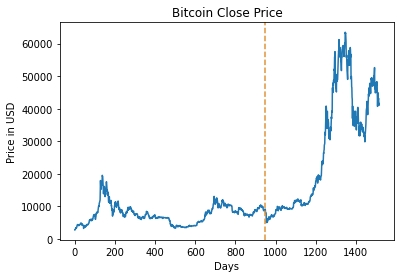

In [ ]:
plt.plot(df['Close'])

plt.title('Bitcoin Close Price');
plt.ylabel('Price in USD')
plt.xlabel('Days')
# plt.xlim([2017,2021])
# plt.xticks([2017,2018,2019,2020,2021])
plt.axvline(x=945, color = '#E39339',linestyle='--')
plt.show()

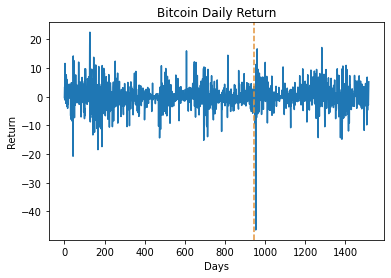

In [ ]:
plt.plot(df['Return'])

plt.title('Bitcoin Daily Return');
plt.ylabel('Return')
plt.xlabel('Days')
# plt.xlim([2017,2021])
# plt.xticks([2017,2018,2019,2020,2021])
plt.axvline(x=945, color = '#E39339',linestyle='--')
plt.show()

# Ethereum

In [ ]:
# df_eth = pd.read_csv('/content/Data Historis ETH_IDR BTC Indonesia.csv')
data= yf.download("ETH-USD",start = '2017-08-01',end='2021-09-30')
df_eth = data_prep(data)

[*********************100%***********************]  1 of 1 completed
Statistika Deskriptif
Skewness -1.0034057509317484
Kurtosis 10.027939814674278
Mean 0.17026995365650693
STD 5.35891585174061
None
count    1517.000000
mean        0.170270
std         5.358916
min       -55.073174
25%        -2.090912
50%         0.157056
75%         2.854136
max        23.474061
Name: Return, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#normal period
df_eth_n=df_eth.iloc[:945]
#pandemic period
df_eth_p=df_eth.iloc[945:]

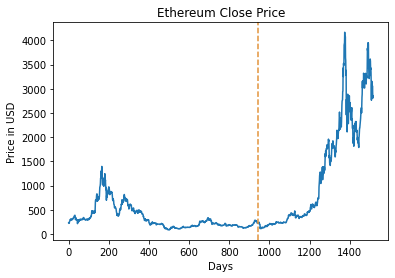

In [ ]:
plt.plot(df_eth['Close'])

plt.title('Ethereum Close Price');
plt.ylabel('Price in USD')
plt.xlabel('Days')
# plt.xlim([2017,2021])
# plt.xticks([2017,2018,2019,2020,2021])
plt.axvline(x=945, color = '#E39339',linestyle='--')
plt.show()

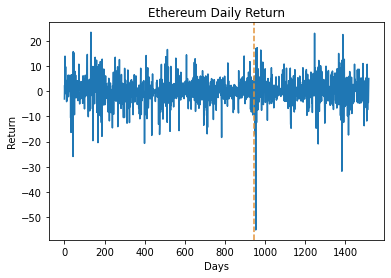

In [ ]:
plt.plot(df_eth['Return'])

plt.title('Ethereum Daily Return');
plt.ylabel('Return')
plt.xlabel('Days')
# plt.xlim([2017,2021])
# plt.xticks([2017,2018,2019,2020,2021])
plt.axvline(x=945, color = '#E39339',linestyle='--')
plt.show()

# Tether

In [ ]:
# df_tether = pd.read_csv('/content/usdt-idr-max.csv')
# df_tether.rename(columns={'snapped_at':'Date','price':'Close'},inplace=True)
data= yf.download("USDT-USD",start = '2017-08-01',end='2021-09-30')
df_tether = data_prep(data)

[*********************100%***********************]  1 of 1 completed
Statistika Deskriptif
Skewness 0.5784174302627387
Kurtosis 30.524647945435518
Mean 0.00022023802410253677
STD 0.5321966370563807
None
count    1517.000000
mean        0.000220
std         0.532197
min        -5.256973
25%        -0.156511
50%        -0.003099
75%         0.149312
max         5.660626
Name: Return, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#normal period
df_tether_n=df_tether.iloc[:945]
#pandemic period
df_tether_p=df_tether.iloc[945:]

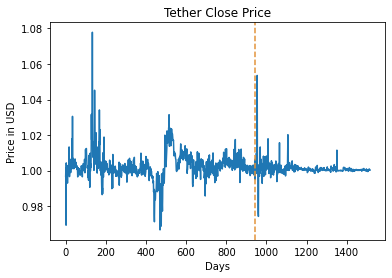

In [ ]:
plt.plot(df_tether['Close'])

plt.title('Tether Close Price');
plt.ylabel('Price in USD')
plt.xlabel('Days')
# plt.xlim([2017,2021])
# plt.xticks([2017,2018,2019,2020,2021])
plt.axvline(x=945, color = '#E39339',linestyle='--')

plt.show()

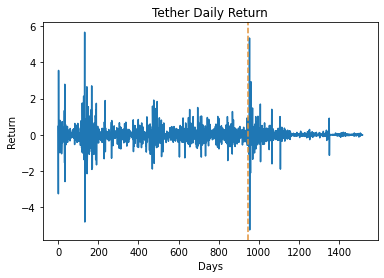

In [ ]:
plt.plot(df_tether['Return'])

plt.title('Tether Daily Return');
plt.ylabel('Return')
plt.xlabel('Days')
# plt.xlim([2017,2021])
# plt.xticks([2017,2018,2019,2020,2021])
plt.axvline(x=945, color = '#E39339',linestyle='--')

plt.show()

# BNB

In [ ]:
data= yf.download("BNB-USD",start = '2017-08-01',end='2021-09-30')
df_bnb = data_prep(data)

[*********************100%***********************]  1 of 1 completed
Statistika Deskriptif
Skewness 0.8996538668880095
Kurtosis 13.84864411023717
Mean 0.5446597772194013
STD 7.378688389022198
None
count    1517.000000
mean        0.544660
std         7.378688
min       -54.308390
25%        -2.439674
50%         0.129921
75%         3.273572
max        67.517387
Name: Return, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#normal period
df_bnb_n=df_bnb.iloc[:945]
#pandemic period
df_bnb_p=df_bnb.iloc[945:]

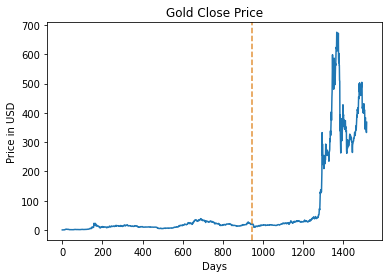

In [ ]:
plt.plot(df_bnb['Close'])

plt.title('Gold Close Price');
plt.ylabel('Price in USD')
plt.xlabel('Days')

plt.axvline(x=945, color = '#E39339',linestyle='--')

plt.show()

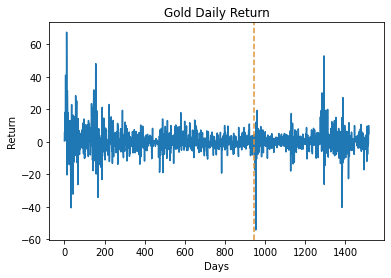

In [ ]:
plt.plot(df_bnb['Return'])

plt.title('Gold Daily Return');
plt.ylabel('Return')
plt.xlabel('Days')
# plt.xlim([2017,2021])
# plt.xticks([2017,2018,2019,2020,2021])
plt.axvline(x=945, color = '#E39339',linestyle='--')

plt.show()

# SVR Function

In [ ]:
#SVR Function. Include evaluation value and graphs
# def svr(X,y,X_val,y_val,kernel,eps,C=3,gamma=3,degree=3):
def svr(X,y,X_val,y_val,param):
  # regressor = SVR(kernel = kernel, C=C, epsilon=eps,gamma=gamma,degree=3)
  regressor = SVR(**param)
  regressor.fit(X,y)
  # score = regressor.score(X,y)

  #Predicting a new result
  score = regressor.score(X,y)
  y_pred = regressor.predict(X_val)
  score_train = regressor.score(X,y)
  score_test = regressor.score(X_val,y_val)

  #SVR Function
  alpha = regressor.dual_coef_
  support_vector = regressor.support_vectors_
  if param['kernel'] =='poly':
    print('w koef: {}'.format(np.matmul(alpha,(param['gamma']**param['degree'])*(support_vector)**param['degree'])))
    print('b koef: {} \n'.format(regressor.intercept_))
  else:
    print('w koef: {}'.format(np.matmul(alpha,support_vector)))
    print('b koef: {} \n'.format(regressor.intercept_))

  #Model Validation
  print("Train score: {}".format(score_train))
  print('Test score: {} \n'.format(score_test))
  print("MSE:", mean_squared_error(y_val,y_pred))
  print("MAE:",mean_absolute_error(y_val,y_pred))
  print("RMSE:", np.sqrt(mean_squared_error(y_val,y_pred)))
  print('AIC {}'.format(calculate_aic(len(X_val),mean_squared_error
                                      (y_val,y_pred,),2)))
  print('BIC {} \n'.format(calculate_bic(len(X_val),mean_squared_error
                                      (y_val,y_pred,),2)))
  print('Statistika Deskriptif Data Populasi')
  print(stat_desc(y_val))
  print('Statistika Deskriptif Prediksi')
  print(stat_desc(y_pred))

  #Plot
  figure(figsize=(10, 6), dpi=80)
  plt.plot(y_val,label='Observed volatility');
  plt.plot(pd.Series(y_pred, index=y_val.index),'r',ls='--',label='SVR forecasted volatility');
  plt.title('Predicted Volatility');
  plt.xlabel('Days')
  plt.ylabel('Volatility')
  plt.legend(loc='upper right');

  return y_pred,regressor

In [ ]:
#SVR Function. Include evaluation value and graphs
def svr2(X,y,X_val,y_val,kernel,eps,C=3,gamma=3,degree=3):
  regressor = SVR(kernel = kernel, C=C, epsilon=eps,gamma=gamma,degree=degree)
  regressor.fit(X,y)
  # score = regressor.score(X,y)

  #Predicting a new result
  score = regressor.score(X,y)
  y_pred = regressor.predict(X_val)
  score_train = regressor.score(X,y)
  score_test = regressor.score(X_val,y_val)

  #SVR Function
  alpha = regressor.dual_coef_
  support_vector = regressor.support_vectors_
  if kernel =='poly':
    print('w koef: {}'.format(np.matmul(alpha,(gamma**degree)*(support_vector)**degree)))
    print('b koef: {} \n'.format(regressor.intercept_))
  else:
    print('w koef: {}'.format(np.matmul(alpha,support_vector)))
    print('b koef: {} \n'.format(regressor.intercept_))

  #Model Validation
  print("Train score: {}".format(score_train))
  print('Test score: {} \n'.format(score_test))
  print("MSE:", mean_squared_error(y_val,y_pred))
  print("MAE:",mean_absolute_error(y_val,y_pred))
  print("RMSE:", np.sqrt(mean_squared_error(y_val,y_pred)))
  print('AIC {}'.format(calculate_aic(len(X_val),mean_squared_error
                                      (y_val,y_pred,),2)))
  print('BIC {} \n'.format(calculate_bic(len(X_val),mean_squared_error
                                      (y_val,y_pred,),2)))
  print('Statistika Deskriptif Data Populasi')
  print(stat_desc(y_val))
  print('Statistika Deskriptif Prediksi')
  print(stat_desc(y_pred))

  #Plot
  figure(figsize=(10, 6), dpi=80)
  plt.plot(y_val,label='Observed volatility');
  plt.plot(pd.Series(y_pred, index=y_val.index),'r',ls='--',label='SVR forecasted volatility');
  plt.title('Predicted Volatility');
  plt.xlabel('Days')
  plt.ylabel('Volatility')
  plt.legend(loc='upper right');

  return y_pred,regressor

#SigOpt (BayesOpt)

In [ ]:
import sigopt

# Create a connection to SigOpt using either your Development or API token
from sigopt import Connection
 
# put your token here
api_token = "HCINYCHGGHFNGADJSXQWTLKSZYHJILYRZWUPRHUWFGXYBLUY"
 
conn = Connection(client_token=api_token)

/usr/local/lib/python3.7/dist-packages/sigopt/interface.py:325: UserWarning:

You're currently using the old SigOpt Experience. Try out the new and improved SigOpt experience by getting started with the docs today. You have until July 2022 to migrate over without experiencing breaking changes.



In [ ]:
def create_model(assignments,kernel):
    model = SVR(
                                C     = assignments['C'],
                                epsilon = assignments['epsilon'],
                                # gamma        = assignments['gamma'],
                                gamma = 3,
                                degree            = assignments['degree'],
                                # degree            = 1,
                                kernel = kernel
                            )
    return model

from sklearn.model_selection import cross_validate

def evaluate_model(assignments,X_train,y_train,X_test,y_test,kernel):
    model = create_model(assignments,kernel)
    probabilities = model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(preds, y_test))
    return [dict(name="RMSE", value=rmse)]
    # dict(name="Accuracy Score", value=model.score(X_test, y_test)),

In [ ]:
def sigopt(X_sg,y_sg,kernel,name,observation_budget=100):
  experiment = conn.experiments().create(
      
      name=name,
  
      parameters=[
          dict(name="C", bounds=dict(min=1e-08,max=100), type="double", transformation="log"),
          dict(name="epsilon", bounds=dict(min=1e-08,max=1), type="double"),
          # dict(name="gamma", bounds=dict(min=1e-08,max=100), type="double", transformation="log"),
          dict(name="degree", bounds=dict(min=1,max=5), type="int")
          ],
  
      metrics=[
          dict(name="RMSE", objective="minimize", strategy="optimize")
          ],
 # dict(name="Accuracy Score", objective="maximize", strategy="store"), 
      observation_budget = observation_budget,
  )
  
  print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

  n_test = m.floor(len(X_sg)/2) #0.5%
  X_train = X_sg.iloc[:-n_test]
  y_train = y_sg.iloc[:-n_test]
  X_val = X_sg.iloc[-n_test:]
  y_val = y_sg.iloc[-n_test:]

  #Optimization Loop
  for _ in range(experiment.observation_budget):
      suggestion = conn.experiments(experiment.id).suggestions().create()
      assignments = suggestion.assignments
      value_dicts = evaluate_model(assignments,X_train,y_train,X_val,y_val,kernel)
  
      conn.experiments(experiment.id).observations().create(
          suggestion=suggestion.id,
          values=value_dicts
      )
      
      #update experiment object
      experiment = conn.experiments(experiment.id).fetch()
  
  assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments  
  
  print("BEST ASSIGNMENTS FOUND: \n", assignments)

  return assignments

In [ ]:
# experiment = conn.experiments().create(
    
#     name="AR-GARCH BTC Volatility",
 
#     parameters=[
#         dict(name="C", bounds=dict(min=1e-08,max=1), type="double", transformation="log"),
#         dict(name="epsilon", bounds=dict(min=1e-08,max=1), type="double"),
#         dict(name="gamma", bounds=dict(min=1e-08,max=1), type="double", transformation="log"),
#         dict(name="degree", bounds=dict(min=1,max=5), type="int"),
#         dict(name="kernel",categorical_values=
#              [dict(name="linear"),dict(name="poly"),dict(name="rbf")]
#              ,type="categorical",)
#         ],
 
#     metrics=[
#         dict(name="Accuracy Score", objective="maximize", strategy="store"),
#         dict(name="RMSE", objective="minimize", strategy="optimize")
#         ],
 
#     observation_budget = 120,
# )
 
# print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

In [ ]:
# #Optimization Loop
# for _ in range(experiment.observation_budget):
#     suggestion = conn.experiments(experiment.id).suggestions().create()
#     assignments = suggestion.assignments
#     value_dicts = evaluate_model(assignments,X_sg,y_sg,X_sg_val,y_sg_val,kernel)
 
#     conn.experiments(experiment.id).observations().create(
#         suggestion=suggestion.id,
#         values=value_dicts
#     )
    
#     #update experiment object
#     experiment = conn.experiments(experiment.id).fetch()
 
# assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments  
 
# print("BEST ASSIGNMENTS FOUND: \n", assignments)

# Bayes-Opt

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV

In [ ]:
def bayesopt(X,y):
  # define search space
  params = dict()
  # params['kernel'] = ['linear','poly','rbf']
  params['C'] = (1e-8, 100.0, 'log-uniform')
  params['gamma'] = (1e-8, 100.0, 'log-uniform')
  # params['degree'] = (1,5)
  params['epsilon'] = (1e-8, 1.0, 'log-uniform')

  n_test = m.floor(len(X)/4) #0.25%
  X_train = X.iloc[:-n_test]
  y_train = y.iloc[:-n_test]
  X_val = X.iloc[-n_test:]
  y_val = y.iloc[-n_test:]

  # params = dict()
  # params['C'] = (5e-2, 5.0, 'uniform')
  # params['gamma'] = (5e-2, 2.0, 'uniform')
  # params['degree'] = (1,5)
  # params['kernel'] = ['linear', 'poly','rbf']
  # params['epsilon'] = (5e-2, 2.0, 'uniform')

  # define evaluation
  # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

  # define evaluation
  tscv = TimeSeriesSplit(n_splits=5)

  # define the search
  search = BayesSearchCV(estimator=SVR(kernel = 'poly',degree=1), search_spaces=params,
                         n_jobs=-1,verbose=False,scoring='neg_mean_squared_error',cv=tscv,n_iter=50)

  # perform the search
  search.fit(X_train, y_train);
  # report the best result
  print('validation score: {}'.format(search.best_score_*-1))
  print('test score: {}'.format(search.score(X_val, y_val)*-1))
  return (search.score(X_val, y_val),search.best_params_)

In [ ]:
def bayesopt2(X,y):
  # define search space
  params = dict()
  params['C'] = (1.0, 100.0, 'log-uniform')
  params['gamma'] = (1.0, 100.0, 'log-uniform')
  params['degree'] = (1,5)
  params['kernel'] = ['poly']
  params['epsilon'] = (1e-8, 1.0, 'log-uniform')

  # define evaluation
  # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

  # define evaluation
  tscv = BlockingTimeSeriesSplit(n_splits = 5)

  # define the search
  search = BayesSearchCV(estimator=SVR(), search_spaces=params,
                         n_jobs=-1,verbose=False,scoring='neg_mean_squared_error',cv=tscv,n_iter=100)

  # perform the search
  search.fit(X, y);
  # report the best result
  return (search.best_score_,search.best_params_)

# RandomSearch

In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
def randomsearch(X_sg,y_sg):
  parameters = dict()
  parameters['C'] = np.arange(1,50,0.1)
  parameters['gamma'] = np.arange(1,50,0.1)
  parameters['degree'] = list(range(1,5))
  parameters['kernel'] = ['linear', 'poly','rbf']
  parameters['epsilon'] = np.arange(1e-08,1,1e-09)
  # parameters = {'C':list(range(1,20)),'epsilon':[1e-09,1e-08,1e-07,1e-06,1e-05]
                # ,'degree':list(range(1,5)),'gamma':list(range(1,15)),'kernel':['linear','poly','rbf']}

  tscv = BlockingTimeSeriesSplit(n_splits = 10)

  svr1 = SVR()
  clf = RandomizedSearchCV(svr1, parameters, scoring='neg_mean_absolute_error',cv=tscv,n_iter=5000)
  clf.fit(X_sg,y_sg)
  return (clf.best_params_)

#Normal Period

## SVR based GARCH (Bitcoin)


In [ ]:
#Step I: SVR-based AR(1) models for return
n_test = m.floor(len(df_n)/4)

X = df_n[['Return']].iloc[:-n_test]
y = df_n['Return'].shift(-1).iloc[:-n_test]
X_val = df_n[['Return']].iloc[-n_test:-1]
y_val = df_n['Return'].shift(-1).iloc[-n_test:-1]

In [ ]:
# score , param_btc_r = bayesopt(X,y)

In [ ]:
# print(score)
# print(param_btc_r)

w koef: [[-1.22186489e-05]]
b koef: [0.3152526] 

Train score: -0.0005718057834072088
Test score: -0.01958297619236493 

MSE: 10.13713419385953
MAE: 2.2122729926044573
RMSE: 3.183886649028123
AIC 548.3082535693479
BIC 555.2274245976363 

Statistika Deskriptif Data Populasi
Skewness 0.02230310215679406
Kurtosis 4.182803439385802
Mean -0.1259959873246479
STD 3.1598925319673516
None
Statistika Deskriptif Prediksi
Skewness -0.011558265458753008
Kurtosis 4.097457830945511
Mean 0.3152538881450662
STD 3.8657824684072e-05
None


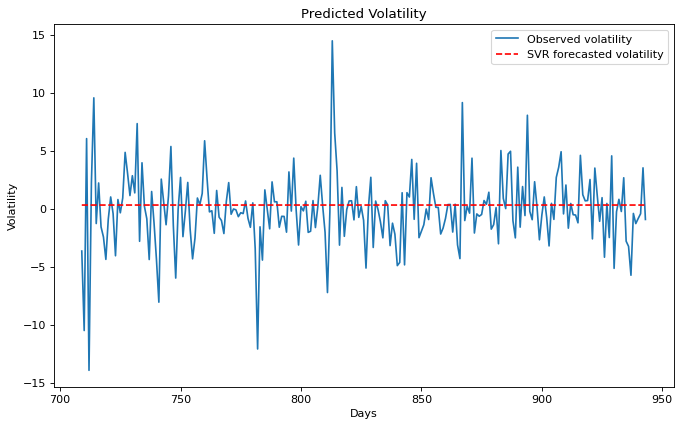

In [ ]:
#SVR Return
y_pred_btc,model_r_btc = svr2(X,y,X_val,y_val,'linear',0.8767052189058064,C=1.2244221205100648e-07)
# y_pred_btc,model_r_btc = svr(X,y,X_val,y_val,param_btc_r)

#sebenernya matriks penilaiannya di Step I ga penting
#yg dicari cuman nilai u 

u_btc =y- model_r_btc.predict(X) 
u_btc_pred_normal= y_val-y_pred_btc #return error
u2 = u_btc**2
u2_pred = u_btc_pred_normal**2

#delete unused data frame
del (X,y,X_val,y_val)

In [ ]:
df_sg = pd.DataFrame(u2.append(u2_pred))
df_sg.rename(columns={'Return':'u2'},inplace=True)
df_sg['vol_prox']=(df_n['Return'].iloc[:-1]-df_n['Return'].iloc[:-1].mean())**2
X_sg,y_sg,X_sg_val,y_sg_val = garch_df(df_sg,1,1)
print('X columns: ',X_sg.columns)
print('y columns: ',y_sg.columns)
del df_sg

X columns:  Index(['u2', 'vol_prox'], dtype='object')
y columns:  Index(['vol_prox_shift1'], dtype='object')


In [ ]:
# score,param_btc_v =bayesopt(X_sg,y_sg)

In [ ]:
# print(score)
# print(param_btc_v)

In [ ]:
# param_btc_v=sigopt(X_sg,np.squeeze(y_sg),'linear','BTC Volatility Normal',observation_budget=50)

w koef: [[9.82776056e-01 1.57244742e-06]]
b koef: [0.10250791] 

Train score: 0.9983311845891479
Test score: 0.9975105712498341 

MSE: 1.525373615374057
MAE: 0.8318900831896067
RMSE: 1.2350601667020344
AIC 103.22625282918865
BIC 110.14542385747697 

Statistika Deskriptif Data Populasi
Skewness 5.416121494891793
Kurtosis 34.377374901977404
Mean 10.063015581644255
STD 24.80642996824821
None
Statistika Deskriptif Prediksi
Skewness 5.423353788496276
Kurtosis 34.31519898167789
Mean 10.113763614285029
STD 24.419842339219393
None


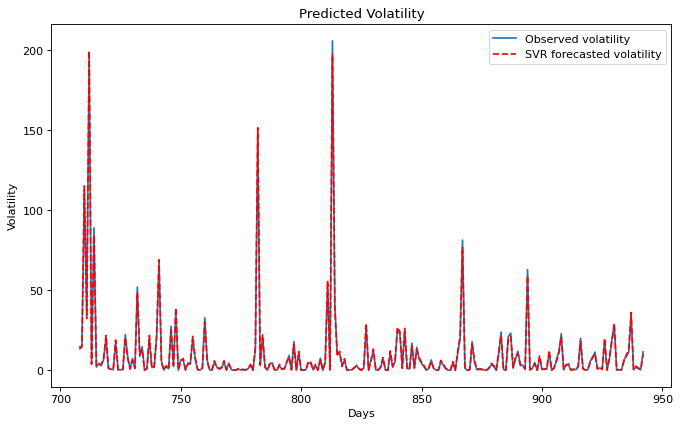

In [ ]:
#BTC Volatility Normal Linear
y_pred_vol_btc_normal_linear,model_vol_btc = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'linear',1,C=100) 

In [ ]:
#Sigopt BTC Volatility Normal rbf 
# param_btc_v=sigopt(X_sg,np.squeeze(y_sg),'rbf','BTC Volatility Normal RBF',observation_budget=100)

w koef: [[170490.57364942  -1466.43131686]]
b koef: [150.06095568] 

Train score: 0.9596197808765644
Test score: 0.9970727933193896 

MSE: 1.7936178478906848
MAE: 0.8203800287762039
RMSE: 1.3392601867787621
AIC 141.2951601780618
BIC 148.2143312063501 

Statistika Deskriptif Data Populasi
Skewness 5.416121494891793
Kurtosis 34.377374901977404
Mean 10.063015581644255
STD 24.80642996824821
None
Statistika Deskriptif Prediksi
Skewness 5.552714571922209
Kurtosis 35.59461475177665
Mean 9.906058376252316
STD 24.73998365455952
None


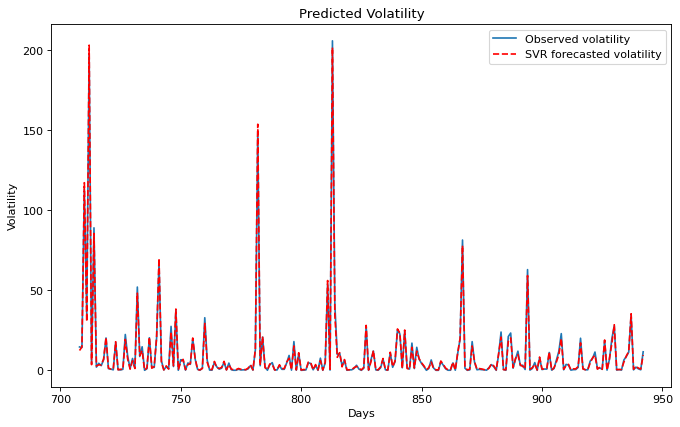

In [ ]:
#BTC Volatility Normal RBF
y_pred_vol_btc,model_vol_btc = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'rbf',0.39834181900007304,C=100.0,gamma=2.7707435373131008e-05) 

In [ ]:
#Sigopt BTC Volatility Normal poly
# param_btc_v=sigopt(X_sg,np.squeeze(y_sg),'poly','BTC Volatility Normal Poly',observation_budget=100)

w koef: [[ 9.64027014e-01 -1.38363776e-04]]
b koef: [0.22253771] 

Train score: 0.9972939837095726
Test score: 0.9966941339686863 

MSE: 2.0256377370877674
MAE: 0.8605098717318643
RMSE: 1.4232490074079684
AIC 169.88287697516824
BIC 176.80204800345655 

Statistika Deskriptif Data Populasi
Skewness 5.416121494891793
Kurtosis 34.377374901977404
Mean 10.063015581644255
STD 24.80642996824821
None
Statistika Deskriptif Prediksi
Skewness 5.423443856970784
Kurtosis 34.31611302210864
Mean 10.041372893570607
STD 23.953690367598213
None


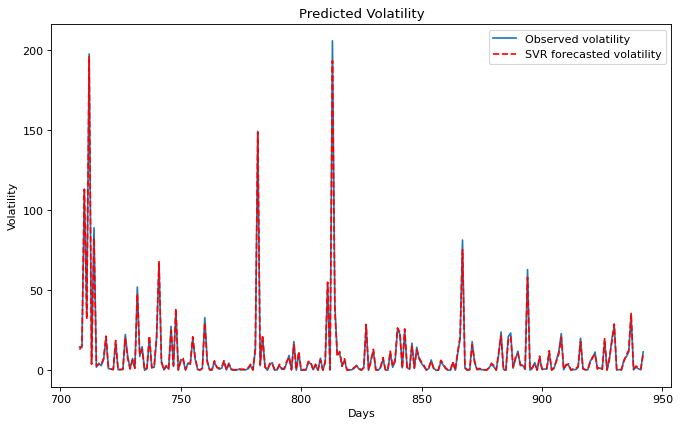

In [ ]:
#BTC Volatility Normal Poly
y_pred_vol_btc,model_vol_btc = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'poly',0.6623788265680192,C=0.000002844476746792268,gamma=71.32126353029514,degree=1) 

In [ ]:
# interactive_plot(df,df_sg,y_sg_val,y_pred_vol_btc)

Jarque-Bera Test
H0: Goodness of fit of the sample data for normality distribution 

JB Stat Test: 5832.385782480956
JB P-val: 0.0
H0 ditolak, sehingga data tidak berdistribusi normal.
Dengan begitu data terindikasi memiliki distribusi ekor tebal


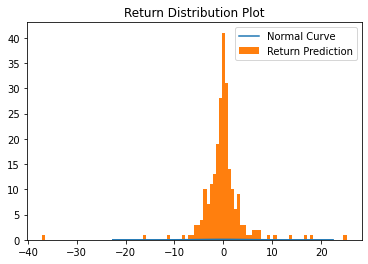

In [ ]:
# Statistik Property
return_pred_btc = vol_return(y_pred_vol_btc)
jb_test(return_pred_btc,0.01)
normal_plot(return_pred_btc)

In [ ]:
del (X_sg,y_sg,X_sg_val,y_sg_val)

## SVR based GARCH (Ethereum)

In [ ]:
#Step I: SVR-based AR(1) models for return
n_test = m.floor(len(df_eth_n)/4)
print('n test: ',n_test)
X = df_eth_n[['Return']].iloc[:-n_test]
y = df_eth_n['Return'].shift(-1).iloc[:-n_test]
X_val = df_eth_n[['Return']].iloc[-n_test:-1]
y_val = df_eth_n['Return'].shift(-1).iloc[-n_test:-1]

n test:  236


In [ ]:
# score , param_eth_r = bayesopt(X,y)

In [ ]:
# print(score)
# print(param_eth_r)

w koef: [[-60.00856901]]
b koef: [3.34368014] 

Train score: 8.715213760501772e-05
Test score: -0.018293841225798246 

MSE: 15.673883637760449
MAE: 2.719063698348933
RMSE: 3.959025591955734
AIC 650.719028204768
BIC 657.6381992330564 

Statistika Deskriptif Data Populasi
Skewness -0.6855970451988604
Kurtosis 4.129972607820948
Mean -0.08834806137320006
STD 3.9316762855430585
None
Statistika Deskriptif Prediksi
Skewness 3.0518272258210515
Kurtosis 13.75555468403424
Mean 0.054992305233310446
STD 0.5272220301095869
None


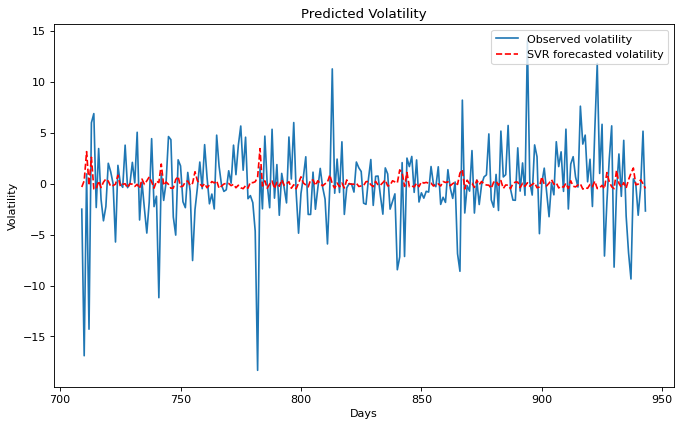

In [ ]:
#ETH Return
y_pred_eth,model_r_eth = svr2(X,y,X_val,y_val,'rbf',2.335202629101557e-07,C=5.689016568285362,gamma=0.0008083818575853543,degree=4)
# y_pred_eth,model_r_eth = svr(X,y,X_val,y_val,param_eth_r)
# y_pred_eth,model_r_eth = svr2(X,y,X_val,y_val,'poly',1.1563254219834587e-08,C=2.6251392044698945e-08,gamma=4.591274987222289e-06,degree=2)

#sebenernya matriks penilaiannya di Step I ga penting
#yg dicari cuman nilai u 

u_eth =y- model_r_eth.predict(X) 
u_eth_pred_normal= y_val-y_pred_eth #return error
u2 = u_eth**2
u2_pred = u_eth_pred_normal**2

del (X,y,X_val,y_val)

In [ ]:
df_sg_eth = pd.DataFrame(u2.append(u2_pred))
df_sg_eth.rename(columns={'Return':'u2'},inplace=True)
df_sg_eth['vol_prox']=(df_eth_n['Return'].iloc[:-1]-df_eth_n['Return'].iloc[:-1].mean())**2

X_sg,y_sg,X_sg_val,y_sg_val = garch_df(df_sg_eth,1,1)
print('X columns: ',X_sg.columns)
print('y columns: ',y_sg.columns)

del df_sg_eth

X columns:  Index(['u2', 'vol_prox'], dtype='object')
y columns:  Index(['vol_prox_shift1'], dtype='object')


In [ ]:
#bayes-opt
# score,param_eth_v =bayesopt(X_sg,y_sg)

In [ ]:
# print(score)
# print(param_eth_v)

In [ ]:
#Sigopt ETH Normal Linear
# param_eth_v=sigopt(X_sg,np.squeeze(y_sg),'linear','ETH Volatility Normal Linear',observation_budget=100)

w koef: [[0.9780699  0.00891195]]
b koef: [0.28572262] 

Train score: 0.9761558127285286
Test score: 0.9904708894790386 

MSE: 13.986037465985
MAE: 1.7495347607539344
RMSE: 3.739791099244047
AIC 623.943984403193
BIC 630.8631554314813 

Statistika Deskriptif Data Populasi
Skewness 5.373670010006375
Kurtosis 34.213919562359195
Mean 15.402714151223892
STD 38.39256816888607
None
Statistika Deskriptif Prediksi
Skewness 5.4756759736903495
Kurtosis 35.90995234461654
Mean 15.744485674089171
STD 38.986517010687905
None


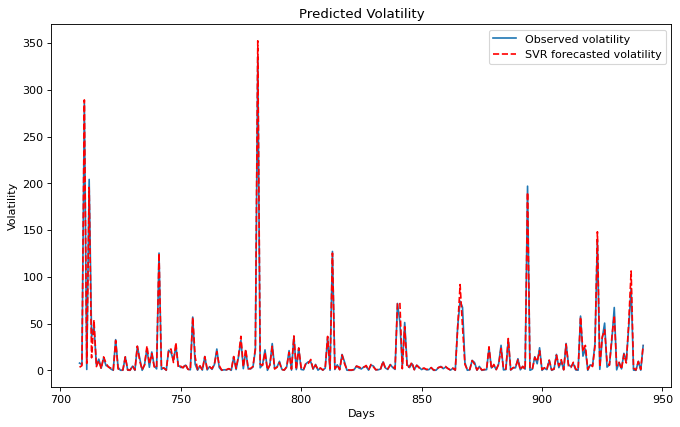

In [ ]:
#ETH Volatility Normal Linear
y_pred_vol_eth_normal_linear,model_vol_eth = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'linear',1,C=100)#current best

In [ ]:
#Sigopt ETH Normal RBF
# param_eth_v=sigopt(X_sg,np.squeeze(y_sg),'rbf','ETH Volatility Normal RBF',observation_budget=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[260152.97530044 -28790.49449661]]
b koef: [181.42523762] 

Train score: 0.9213778679089444
Test score: 0.9872300485097768 

MSE: 18.742674837090128
MAE: 1.800810440021361
RMSE: 4.329281099338564
AIC 692.7387051710161
BIC 699.6578761993045 

Statistika Deskriptif Data Populasi
Skewness [5.37367001]
Kurtosis [34.21391956]
Mean vol_prox_shift1    15.402714
dtype: float64
STD vol_prox_shift1    38.392568
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 5.7921178325546805
Kurtosis 40.17759374671602
Mean 15.325831572114069
STD 39.73907171751322
None


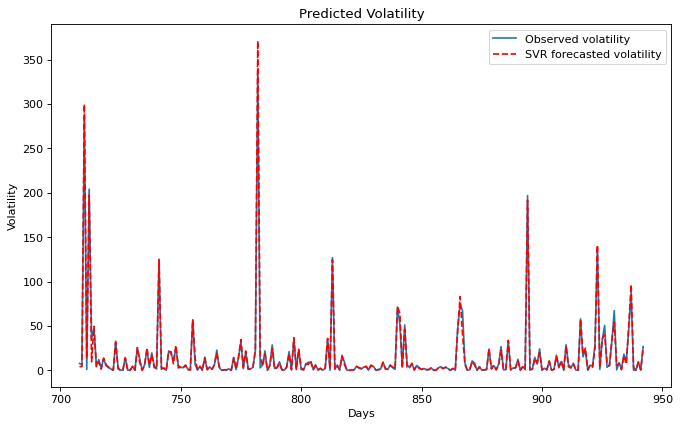

In [ ]:
#ETH Volatility Normal RBF
y_pred_vol_eth,model_vol_eth = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'rbf',1e-08,C=100,gamma=4.019312090042139e-05)#current best

In [ ]:
#Sigopt ETH Normal Poly
# param_eth_v=sigopt(X_sg,np.squeeze(y_sg),'poly','ETH Volatility Normal Poly',observation_budget=30)

# bayes-opt
# score,param_eth_v =bayesopt(X_sg,y_sg)
# print(score)
# print(param_eth_v)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[0.98009125 0.01692937]]
b koef: [0.02009776] 

Train score: 0.9764085937801357
Test score: 0.9902884887906258 

MSE: 14.253750056404883
MAE: 1.7583535124328828
RMSE: 3.775413892065992
AIC 628.3997079774573
BIC 635.3188790057457 

Statistika Deskriptif Data Populasi
Skewness [5.37367001]
Kurtosis [34.21391956]
Mean vol_prox_shift1    15.402714
dtype: float64
STD vol_prox_shift1    38.392568
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 5.4742555815587695
Kurtosis 35.900449412057
Mean 15.635090507508917
STD 39.06834091659207
None


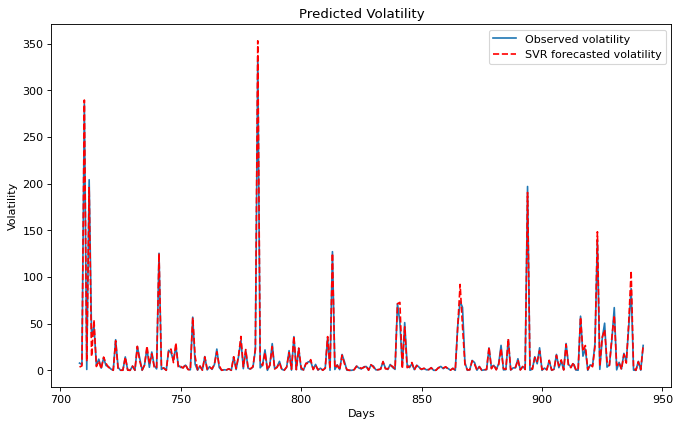

In [ ]:
#belom bener
#ETH Volatility Normal Poly
y_pred_vol_eth,model_vol_eth = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'poly',0.006527818312210536,
                                    C=0.00439077108884808,gamma=1.6775918838615642,degree=1)#bayestopt

In [ ]:
# interactive_plot(df_eth,df_sg_eth,y_sg_val,y_pred_vol_eth)

Jarque-Bera Test
H0: Goodness of fit of the sample data for normality distribution 

JB Stat Test: 10164.185390881163
JB P-val: 0.0
H0 ditolak, sehingga data tidak berdistribusi normal.
Dengan begitu data terindikasi memiliki distribusi ekor tebal


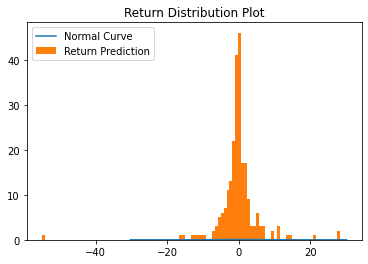

In [ ]:
# Statistik Property
return_pred_eth = vol_return(y_pred_vol_eth)
jb_test(return_pred_eth,0.01)
normal_plot(return_pred_eth)

In [ ]:
del (X_sg,y_sg,X_sg_val,y_sg_val)

## SVR based GARCH (Tether)

In [ ]:
#Step I: SVR-based AR(1) models for return
n_test = m.floor(len(df_tether_n)/4)
print('n test: ',n_test)
X = df_tether_n[['Return']].iloc[:-n_test]
y = df_tether_n['Return'].shift(-1).iloc[:-n_test]
X_val = df_tether_n[['Return']].iloc[-n_test:-1]
y_val = df_tether_n['Return'].shift(-1).iloc[-n_test:-1]

n test:  236


In [ ]:
#bayes-opt
# score,param_tehter_r =bayesopt(X,y)

In [ ]:
# print(score)
# print(param_tehter_r)

w koef: [[-0.37956167]]
b koef: [0.05534207] 

Train score: 0.14445952304912368
Test score: 0.14086820696660318 

MSE: 0.12676806708324764
MAE: 0.27276860861782737
RMSE: 0.35604503518971814
AIC -481.36808481086507
BIC -474.44891378257677 

Statistika Deskriptif Data Populasi
Skewness -0.012260653091886727
Kurtosis 1.6782748041886846
Mean -0.001770181934945393
STD 0.3849470902461672
None
Statistika Deskriptif Prediksi
Skewness -0.02518131814228296
Kurtosis 1.696596464118973
Mean 0.05558764698018503
STD 0.14677755995133637
None


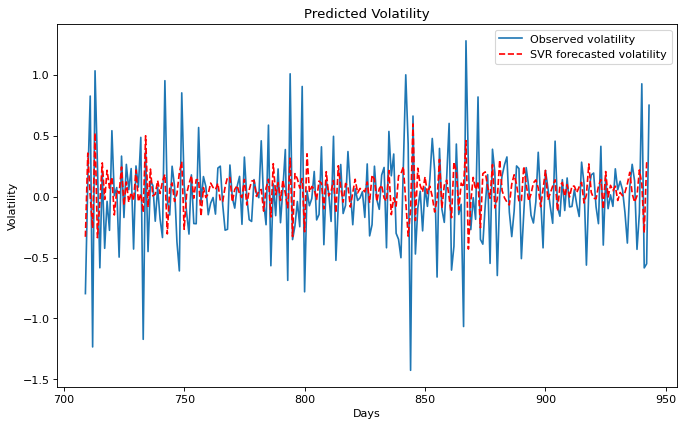

In [ ]:
#Tether Return
y_pred_tether,model_r_tether = svr2(X,y,X_val,y_val,'linear',1,C=0.07347081517563474)
# y_pred_tether,model_r_tether = svr(X,y,X_val,y_val,param_tehter_r)
#sebenernya matriks penilaiannya di Step I ga penting
#yg dicari cuman nilai u 

u_tether =y- model_r_tether.predict(X) 
u_tether_pred_normal= y_val-y_pred_tether #return error
u2 = u_tether**2
u2_pred = u_tether_pred_normal**2

del (X,y,X_val,y_val)

In [ ]:
df_sg_tether = pd.DataFrame(u2.append(u2_pred))
df_sg_tether.rename(columns={'Return':'u2'},inplace=True)
df_sg_tether['vol_prox']=(df_tether_n['Return'].iloc[:-1]-df_tether_n['Return'].iloc[:-1].mean())**2
X_sg,y_sg,X_sg_val,y_sg_val = garch_df(df_sg_tether,1,1)
print('X columns: ',X_sg.columns)
print('y columns: ',y_sg.columns)

del df_sg_tether

X columns:  Index(['u2', 'vol_prox'], dtype='object')
y columns:  Index(['vol_prox_shift1'], dtype='object')


In [ ]:
# GridSearch
# param = randomsearch(X_sg,y_sg)
# param

In [ ]:
#bayes-opt
# score,param_tehter_v =bayesopt2(X_sg,y_sg)

In [ ]:
# print(score)
# print(param_tehter_v)

In [ ]:
# param= {'epsilon':1e-06,
#             'C':18,
#         'gamma':10,
#         'kernel':'rbf'} #from Grid Search

In [ ]:
#Sigopt Tether Normal Linear
# param_tether_v=sigopt(X_sg,np.squeeze(y_sg),'linear','Tether Volatility Normal Linear',observation_budget=100)

w koef: [[0.78881706 0.16533343]]
b koef: [0.01242547] 

Train score: 0.7802454771284787
Test score: 0.7275574296657603 

MSE: 0.022520242226570713
MAE: 0.08046134157601856
RMSE: 0.15006745891954962
AIC -887.4350691304576
BIC -880.5158981021692 

Statistika Deskriptif Data Populasi
Skewness 3.5281044613410106
Kurtosis 14.326654883738215
Mean 0.14953926300137718
STD 0.28812108839859357
None
Statistika Deskriptif Prediksi
Skewness 3.1283324468745097
Kurtosis 12.33258927809119
Mean 0.1385548701474172
STD 0.19099048894475293
None


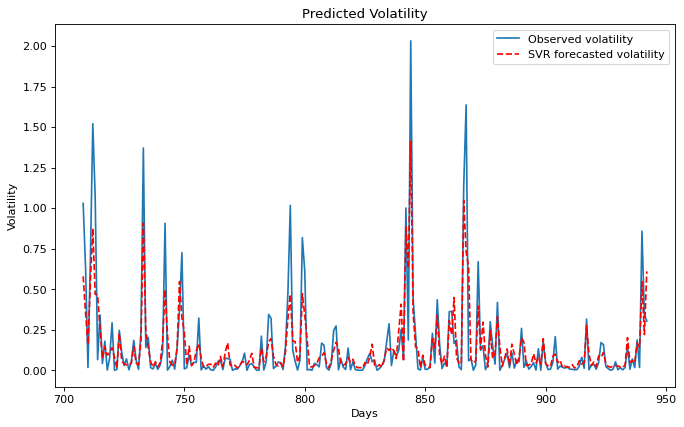

In [ ]:
#Tether Volatility Normal Linear
y_pred_vol_tether,model_v_tether = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'linear',0.023946387414768545,C=0.008749877225668789) 

In [ ]:
#Sigopt Tether Normal RBF
# param_tether_v=sigopt(X_sg,np.squeeze(y_sg),'rbf','Tether Volatility Normal RBF',observation_budget=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[21.38372133 11.98632874]]
b koef: [1.66443923] 

Train score: 0.22027154747484
Test score: 0.7604988526422308 

MSE: 0.019797287352786047
MAE: 0.07367003840264862
RMSE: 0.14070283349238583
AIC -917.7194329671905
BIC -910.8002619389022 

Statistika Deskriptif Data Populasi
Skewness [3.52810446]
Kurtosis [14.32665488]
Mean vol_prox_shift1    0.149539
dtype: float64
STD vol_prox_shift1    0.288121
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 3.6818623032815085
Kurtosis 17.260991102155334
Mean 0.13022520328032988
STD 0.22179800998427596
None


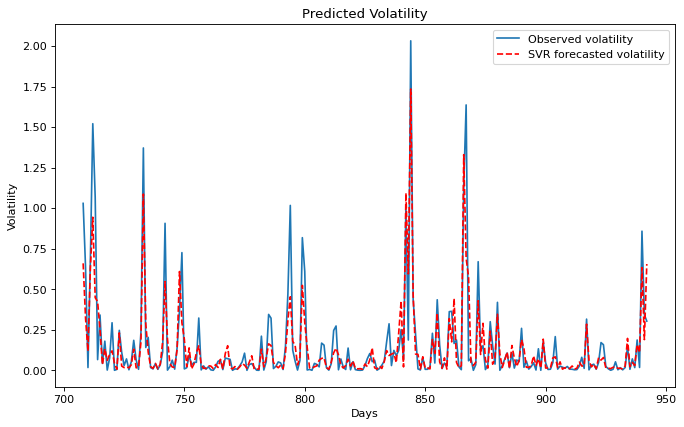

In [ ]:
#Tether Volatility Normal RBF
y_pred_vol_tether,model_v_tether = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'rbf',1e-08,C=0.20402457267458202,gamma=0.17878061106924634) #grid search


In [ ]:
#Sigopt Tether Normal Poly
# param_tether_v=sigopt(X_sg,np.squeeze(y_sg),'poly','Tether Volatility Normal Poly',observation_budget=100)

# #bayes-opt
# score,param_tehter_v =bayesopt(X_sg,y_sg)
# print(score)
# print(param_tether_v)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[1.00909779 0.20071409]]
b koef: [-0.00468279] 

Train score: 0.7947149624535781
Test score: 0.7755089393316228 

MSE: 0.018556545908920547
MAE: 0.07302283004154142
RMSE: 0.13622241338678648
AIC -932.9291781523723
BIC -926.0100071240839 

Statistika Deskriptif Data Populasi
Skewness [3.52810446]
Kurtosis [14.32665488]
Mean vol_prox_shift1    0.149539
dtype: float64
STD vol_prox_shift1    0.288121
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 3.1542732764715846
Kurtosis 12.561153607271251
Mean 0.15506437929109795
STD 0.24307937106794167
None


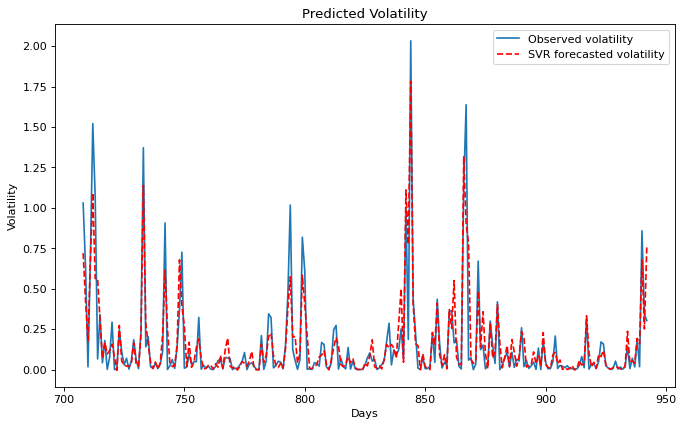

In [ ]:
#Tether Volatility Normal Poly
y_pred_vol_tether_normal_poly,model_v_tether = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'poly',0.0005071318357779311
                                        ,C=0.5396082215345843,degree =1) #bayesopt 0.13622241338678648


In [ ]:
# interactive_plot(df_tether,df_sg_tether,y_sg_val,y_pred_vol_tether)

Jarque-Bera Test
H0: Goodness of fit of the sample data for normality distribution 

JB Stat Test: 213.4543348933549
JB P-val: 0.0
H0 ditolak, sehingga data tidak berdistribusi normal.
Dengan begitu data terindikasi memiliki distribusi ekor tebal


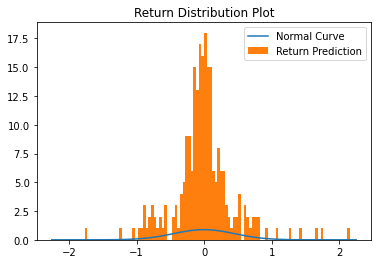

In [ ]:
# Statistik Property
return_pred_tether = vol_return(y_pred_vol_tether)
jb_test(return_pred_tether,0.01)
normal_plot(return_pred_tether)

## SVR based GARCH (BNB)

In [ ]:
#Step I: SVR-based AR(1) models for return
n_test = m.floor(len(df_bnb_n)/4)
print('n test: ',n_test)
X = df_bnb_n[['Return']].iloc[:-n_test]
y = df_bnb_n['Return'].shift(-1).iloc[:-n_test]
X_val = df_bnb_n[['Return']].iloc[-n_test:-1]
y_val = df_bnb_n['Return'].shift(-1).iloc[-n_test:-1]

n test:  236


In [ ]:
#bayes-opt
# score,param_bnb_r =bayesopt(X,y)

In [ ]:
# print(score)
# print(param_bnb_r)
# [('C', 1e-08), ('degree', 1), ('epsilon', 1.0), ('gamma', 100.0), ('kernel', 'linear')])

w koef: [[2.30332037e-06]]
b koef: [0.22198023] 

Train score: -0.004689025098500554
Test score: -0.012288402485435057 

MSE: 14.92738279202755
MAE: 2.7931382138463343
RMSE: 3.8635971311754997
AIC 639.2513649343348
BIC 646.1705359626231 

Statistika Deskriptif Data Populasi
Skewness -0.4624521453757467
Kurtosis 2.549049408185806
Mean -0.20370748802766114
STD 3.848271520252945
None
Statistika Deskriptif Prediksi
Skewness 6.69036272623467
Kurtosis 65.8007810239069
Mean 0.2220147237321694
STD 7.341580352886999e-05
None


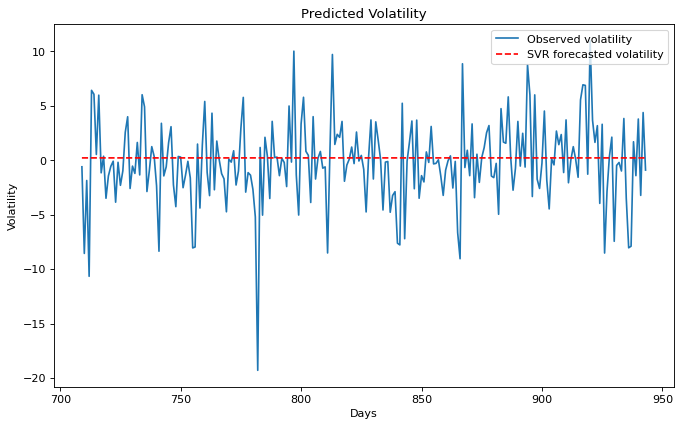

In [ ]:
#BNB Return
y_pred_bnb,model_r_bnb = svr2(X,y,X_val,y_val,'poly',0.9661584288706332,C=1.909263439708957e-07,gamma=0.033497738411047646,degree=2)
# y_pred_gold,model_r_gold = svr(X,y,X_val,y_val,param_g_r)
#sebenernya matriks penilaiannya di Step I ga penting
#yg dicari cuman nilai u 

u_bnb =y- model_r_bnb.predict(X) 
u_bnb_pred_normal= y_val-y_pred_bnb #return error
u2 = u_bnb**2
u2_pred = u_bnb_pred_normal**2

del (X,y,X_val,y_val)

In [ ]:
df_sg_bnb = pd.DataFrame(u2.append(u2_pred))
df_sg_bnb.rename(columns={'Return':'u2'},inplace=True)
df_sg_bnb['vol_prox']=(df_bnb_n['Return'].iloc[:-1]-df_bnb_n['Return'].iloc[:-1].mean())**2
X_sg,y_sg,X_sg_val,y_sg_val = garch_df(df_sg_bnb,1,1)
print('X columns: ',X_sg.columns)
print('y columns: ',y_sg.columns)

del df_sg_bnb

X columns:  Index(['u2', 'vol_prox'], dtype='object')
y columns:  Index(['vol_prox_shift1'], dtype='object')


In [ ]:
#bayes-opt
# score,param_g_v =bayesopt2(X_sg,y_sg)

In [ ]:
# print(score)
# print(param_g_v)

In [ ]:
#Sigopt BNB Normal Linear
# param_bnb_v=sigopt(X_sg,np.squeeze(y_sg),'linear','BNB Volatility Normal Linear',observation_budget=100)

w koef: [[ 0.98512856 -0.00252692]]
b koef: [0.25226676] 

Train score: 0.9995210162725094
Test score: 0.9927746326521835 

MSE: 7.984179693979276
MAE: 1.9321035369922983
RMSE: 2.825629079334242
AIC 492.20358069645283
BIC 499.12275172474114 

Statistika Deskriptif Data Populasi
Skewness 6.9508978043073215
Kurtosis 70.11500092106364
Mean 15.481145650913398
STD 33.31280385700482
None
Statistika Deskriptif Prediksi
Skewness 6.823731534403238
Kurtosis 68.03865934459381
Mean 15.08860840045188
STD 31.866655202284143
None


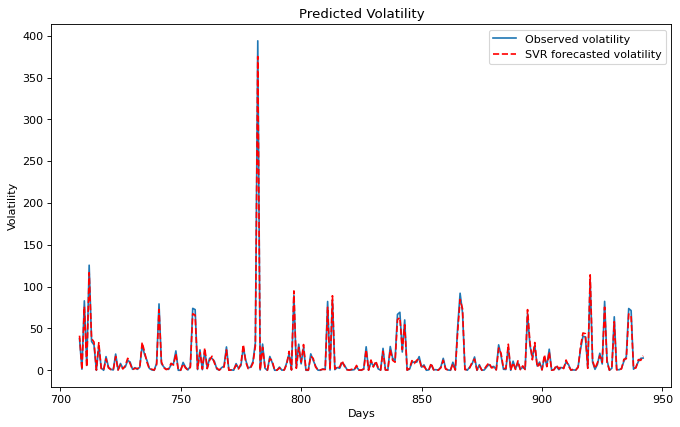

In [ ]:
#BNB Volatility Normal Linear
y_pred_vol_bnb_normal_linear,model_v_bnb = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),
                                  'linear',0.6900403145773912,C=19.54293812717903)


In [ ]:
#Sigopt BNB Normal RBF
# param_bnb_v=sigopt(X_sg,np.squeeze(y_sg),'rbf','BNB Volatility Normal RBF',observation_budget=100)

w koef: [[2549379.00693304  258022.34344664]]
b koef: [314.20864453] 

Train score: 0.39106534099843304
Test score: 0.9923028780550672 

MSE: 8.505478237502427
MAE: 2.005507084758577
RMSE: 2.9164153060739526
AIC 507.0669567901063
BIC 513.9861278183946 

Statistika Deskriptif Data Populasi
Skewness 6.9508978043073215
Kurtosis 70.11500092106364
Mean 15.481145650913398
STD 33.31280385700482
None
Statistika Deskriptif Prediksi
Skewness 6.547090895147201
Kurtosis 63.64685392495214
Mean 15.518653804841508
STD 32.70445634704764
None


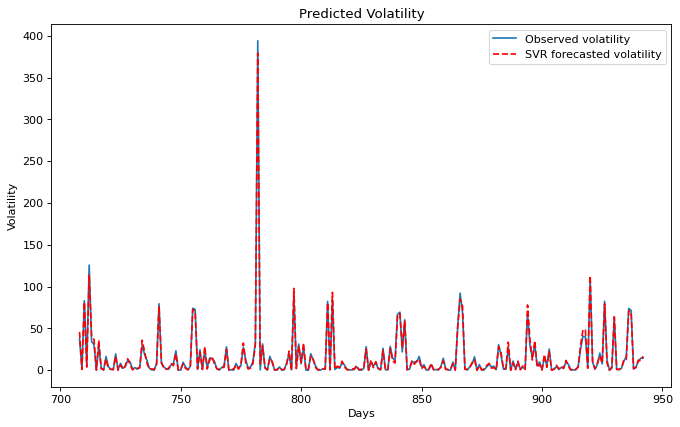

In [ ]:
#BNB Volatility Normal RBF
y_pred_vol_bnb,model_v_bnb = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'rbf',0.5760991803706553,C=100.0,gamma=9.848969454446339e-05)

In [ ]:
#Sigopt BNB Normal Poly
# param_bnb_v=sigopt(X_sg,np.squeeze(y_sg),'poly','BNB Volatility Normal Poly',observation_budget=30)

w koef: [[0.97861587 0.00138464]]
b koef: [0.13536921] 

Train score: 0.999407373850592
Test score: 0.9920960292821009 

MSE: 8.734050390770356
MAE: 1.9722774736062456
RMSE: 2.955342685843785
AIC 513.2988677673331
BIC 520.2180387956215 

Statistika Deskriptif Data Populasi
Skewness 6.9508978043073215
Kurtosis 70.11500092106364
Mean 15.481145650913398
STD 33.31280385700482
None
Statistika Deskriptif Prediksi
Skewness 6.821988288522253
Kurtosis 68.01268062013904
Mean 14.93439661531621
STD 31.664793326807185
None


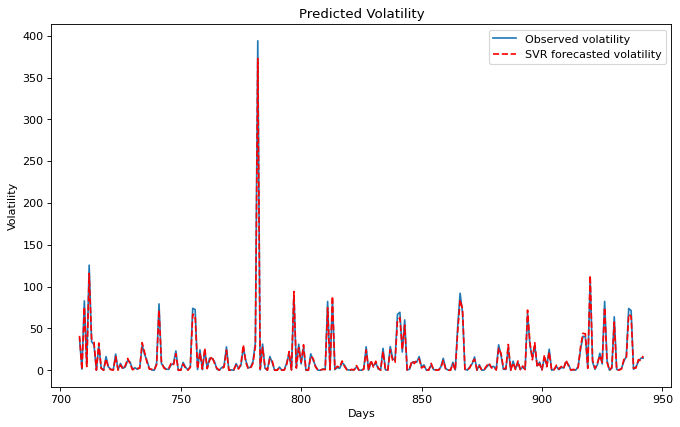

In [ ]:
#BNB Volatility Normal Poly
y_pred_vol_bnb,model_v_bnb = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'poly',0.516345297698399,C=59.92779959875314,gamma=0.000001526875042664928,degree=1)

In [ ]:
# interactive_plot(df_g,df_sg_g,y_sg_val,y_pred_vol_gold)

Jarque-Bera Test
H0: Goodness of fit of the sample data for normality distribution 

JB Stat Test: 26115.181772032392
JB P-val: 0.0
H0 ditolak, sehingga data tidak berdistribusi normal.
Dengan begitu data terindikasi memiliki distribusi ekor tebal


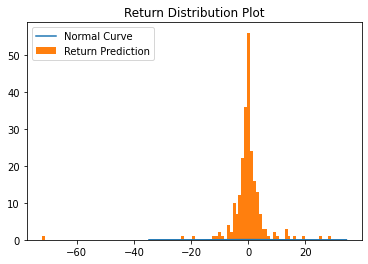

In [ ]:
# Statistik Property
return_pred_gold = vol_return(y_pred_vol_bnb)
jb_test(return_pred_gold,0.01)
normal_plot(return_pred_gold)

#Pandemic Period

## SVR based GARCH (Bitcoin)


In [ ]:
#Step I: SVR-based AR(1) models for return
n_test = m.floor(len(df_p)/4)

X = df_p[['Return']].iloc[:-n_test]
y = df_p['Return'].shift(-1).iloc[:-n_test]
X_val = df_p[['Return']].iloc[-n_test:-1]
y_val = df_p['Return'].shift(-1).iloc[-n_test:-1]

In [ ]:
# score , param_btc_r = bayesopt(X,y)

In [ ]:
# print(score)
# print(param_btc_r)

w koef: [[-0.10128913]]
b koef: [0.40227451] 

Train score: 0.008020606093856686
Test score: -0.0029906123686540553 

MSE: 19.938418190642544
MAE: 3.32567833658716
RMSE: 4.465245591302067
AIC 428.9560774765984
BIC 434.8677315918009 

Statistika Deskriptif Data Populasi
Skewness -0.4635972107028746
Kurtosis 1.1508261837176388
Mean -0.18199223463051103
STD 4.47436626700606
None
Statistika Deskriptif Prediksi
Skewness 0.46479412463921466
Kurtosis 1.2031788712729048
Mean 0.42335989367445626
STD 0.4494870850096342
None


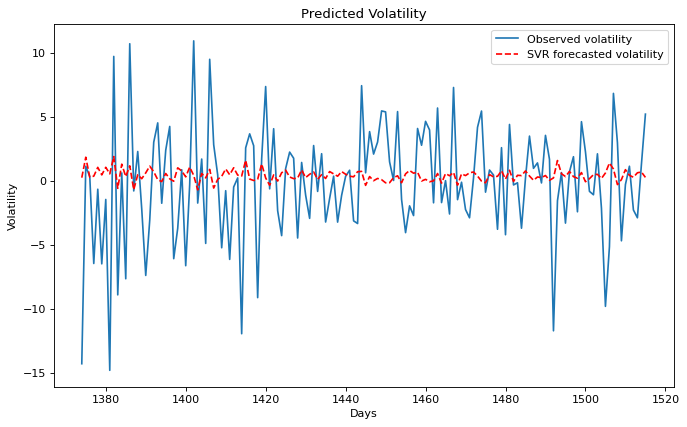

In [ ]:
#SVR Return
y_pred_btc,model_r_btc = svr2(X,y,X_val,y_val,'linear',1.907954507566158e-05,C=0.002980746435644599)

#sebenernya matriks penilaiannya di Step I ga penting
#yg dicari cuman nilai u 

u_btc =y- model_r_btc.predict(X) 
u_btc_pred_pandemic= y_val-y_pred_btc #return error
u2 = u_btc**2
u2_pred = u_btc_pred_pandemic**2

In [ ]:
df_sg = pd.DataFrame(u2.append(u2_pred))
df_sg.rename(columns={'Return':'u2'},inplace=True)
df_sg['vol_prox']=(df_p['Return'].iloc[:-1]-df_p['Return'].iloc[:-1].mean())**2
X_sg,y_sg,X_sg_val,y_sg_val = garch_df(df_sg,1,1)
print('X columns: ',X_sg.columns)
print('y columns: ',y_sg.columns)

X columns:  Index(['u2', 'vol_prox'], dtype='object')
y columns:  Index(['vol_prox_shift1'], dtype='object')


In [ ]:
# score,param_btc_v =bayesopt(X_sg,y_sg)

In [ ]:
# print(score)
# print(param_btc_v)

In [ ]:
#Sigopt BTC Volatility Pandemic Linear
# param_btc_v=sigopt(X_sg,np.squeeze(y_sg),'linear','BTC Volatility Normal',observation_budget=100)

w koef: [[0.9961791  0.03308437]]
b koef: [-0.32477053] 

Train score: 0.9991940924087337
Test score: 0.9882390250571799 

MSE: 15.741230348062047
MAE: 2.2373849971054853
RMSE: 3.9675219404638518
AIC 395.3922437800091
BIC 401.3038978952116 

Statistika Deskriptif Data Populasi
Skewness 3.348105856795506
Kurtosis 12.834553164890314
Mean 19.92354829710888
STD 36.714049625513276
None
Statistika Deskriptif Prediksi
Skewness 3.5266059699883643
Kurtosis 14.607936247567334
Mean 20.03256798891703
STD 35.9456958615237
None


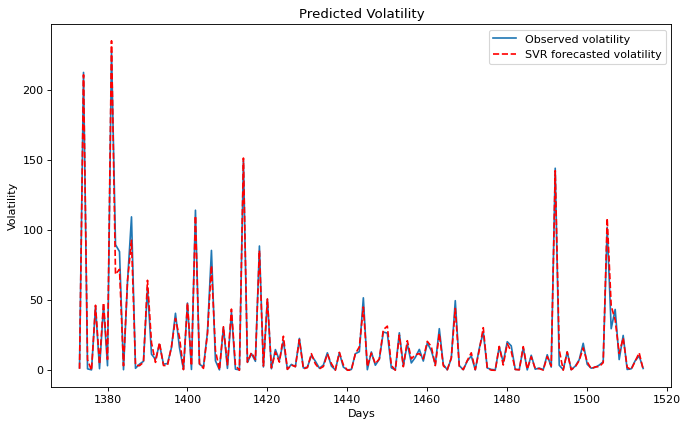

In [ ]:
#BTC Volatility Pandemic Linear
y_pred_vol_btc_pandemic_linear,model_vol_btc = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'linear',1,C=100) 

In [ ]:
# param_btc_v=sigopt(X_sg,np.squeeze(y_sg),'rbf','BTC Volatility Normal RBF',observation_budget=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[310068.84651889 -18028.09964455]]
b koef: [121.14397215] 

Train score: 0.23948642994685743
Test score: 0.9813747345213168 

MSE: 24.92859610867077
MAE: 2.246087721435211
RMSE: 4.992854505057279
AIC 460.674212731943
BIC 466.5858668471455 

Statistika Deskriptif Data Populasi
Skewness [3.34810586]
Kurtosis [12.83455316]
Mean vol_prox_shift1    19.923548
dtype: float64
STD vol_prox_shift1    36.71405
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 3.519099345098231
Kurtosis 14.197332625660326
Mean 19.03580885252903
STD 35.11240056844147
None


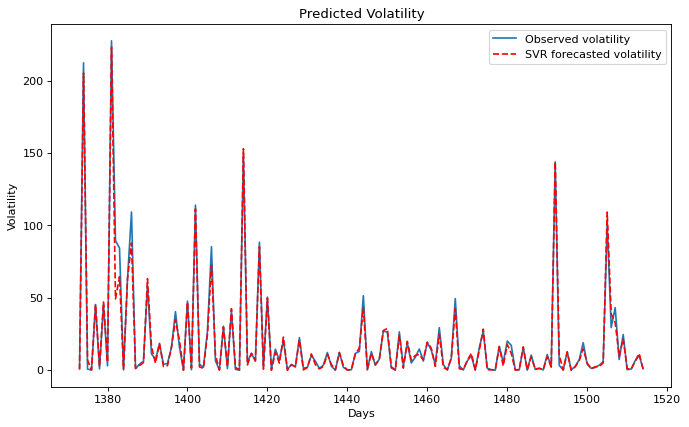

In [ ]:
#BTC Volatility Pandemic RBF
y_pred_vol_btc,model_vol_btc = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'rbf',0.019968280251032672,C=100,gamma=6.479688705503783e-06) 

In [ ]:
#Sigopt Volatility Pandemic Poly
# param_btc_v=sigopt(X_sg,np.squeeze(y_sg),'poly','BTC Volatility Normal Poly',observation_budget=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[0.99496936 0.03838839]]
b koef: [-0.1818678] 

Train score: 0.9991910854835883
Test score: 0.9881110761308534 

MSE: 15.912480906105454
MAE: 2.2807324471730506
RMSE: 3.9890451120669788
AIC 396.92873448122316
BIC 402.84038859642567 

Statistika Deskriptif Data Populasi
Skewness [3.34810586]
Kurtosis [12.83455316]
Mean vol_prox_shift1    19.923548
dtype: float64
STD vol_prox_shift1    36.71405
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 3.5227406773504817
Kurtosis 14.576580115991913
Mean 20.25792527127036
STD 35.90173142876881
None


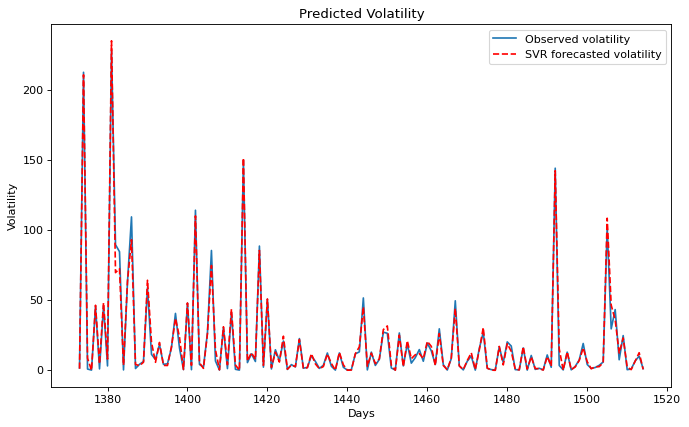

In [ ]:
#BTC Volatility Pandemic Poly
y_pred_vol_btc,model_vol_btc = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'poly',
                                    0.5500749387102819,C=0.16345206965288836,
                                    gamma=72.76702063727815,degree=1) 

In [ ]:
# interactive_plot(df,df_sg,y_sg_val,y_pred_vol_btc)

Jarque-Bera Test
H0: Goodness of fit of the sample data for normality distribution 

JB Stat Test: 2892.206967961917
JB P-val: 0.0
H0 ditolak, sehingga data tidak berdistribusi normal.
Dengan begitu data terindikasi memiliki distribusi ekor tebal


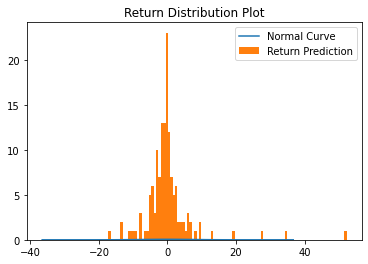

In [ ]:
# Statistik Property
return_pred_btc = vol_return(y_pred_vol_btc)
jb_test(return_pred_btc,0.01)
normal_plot(return_pred_btc)

## SVR based GARCH (Ethereum)

In [ ]:
#Step I: SVR-based AR(1) models for return
n_test = m.floor(len(df_eth_p)/4)
print('n test: ',n_test)
X = df_eth_p[['Return']].iloc[:-n_test]
y = df_eth_p['Return'].shift(-1).iloc[:-n_test]
X_val = df_eth_p[['Return']].iloc[-n_test:-1]
y_val = df_eth_p['Return'].shift(-1).iloc[-n_test:-1]

n test:  143


In [ ]:
# score , param_eth_r = bayesopt(X,y)

In [ ]:
# print(score)
# print(param_eth_r)

w koef: [[-0.01698158]]
b koef: [0.63802605] 

Train score: 0.0028896837273770792
Test score: -0.014282243034243969 

MSE: 41.00560333180355
MAE: 4.6329991281473415
RMSE: 6.403561769187797
AIC 531.3466388073795
BIC 537.258292922582 

Statistika Deskriptif Data Populasi
Skewness -0.7203825134270445
Kurtosis 4.203512211398348
Mean -0.2312906576798813
STD 6.38082461686305
None
Statistika Deskriptif Prediksi
Skewness 0.7200888617177664
Kurtosis 4.198064222807558
Mean 0.6419231432330175
STD 0.10800039404899886
None


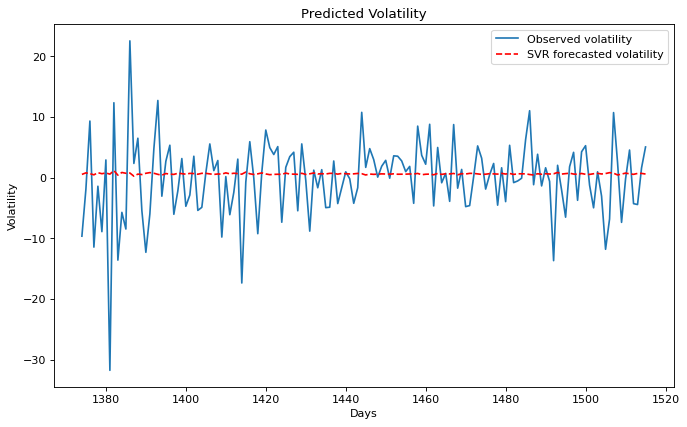

In [ ]:
#ETH Return
y_pred_eth,model_r_eth = svr2(X,y,X_val,y_val,'linear',1e-08,C= 8.801980155219091e-05)
# y_pred_eth,model_r_eth = svr(X,y,X_val,y_val,param_eth_r)

#sebenernya matriks penilaiannya di Step I ga penting
#yg dicari cuman nilai u 

u_eth =y- model_r_eth.predict(X) 
u_eth_pred_pandemic= y_val-y_pred_eth #return error
u2 = u_eth**2
u2_pred = u_eth_pred_pandemic**2

In [ ]:
df_sg_eth = pd.DataFrame(u2.append(u2_pred))
df_sg_eth.rename(columns={'Return':'u2'},inplace=True)
df_sg_eth['vol_prox']=(df_eth_p['Return'].iloc[:-1]-df_eth_p['Return'].iloc[:-1].mean())**2

X_sg,y_sg,X_sg_val,y_sg_val = garch_df(df_sg_eth,1,1)
print('X columns: ',X_sg.columns)
print('y columns: ',y_sg.columns)

X columns:  Index(['u2', 'vol_prox'], dtype='object')
y columns:  Index(['vol_prox_shift1'], dtype='object')


In [ ]:
#bayes-opt
# score,param_eth_v =bayesopt(X_sg,y_sg)

In [ ]:
# print(score)
# print(param_eth_v)

In [ ]:
# param_eth_v=sigopt(X_sg,np.squeeze(y_sg),'linear','ETH Volatility Normal Linear',observation_budget=100)

w koef: [[0.991551   0.01207398]]
b koef: [-0.03261768] 

Train score: 0.9998384760175049
Test score: 0.9992685062780682 

MSE: 7.837062662425745
MAE: 1.8497835225644488
RMSE: 2.7994754262943164
AIC 296.3587027331663
BIC 302.2703568483688 

Statistika Deskriptif Data Populasi
Skewness 7.045993281765318
Kurtosis 60.19276529819491
Mean 40.90304887260101
STD 103.87378906480407
None
Statistika Deskriptif Prediksi
Skewness 7.085064971463797
Kurtosis 61.04250086855248
Mean 41.13553654762715
STD 103.03475189376239
None


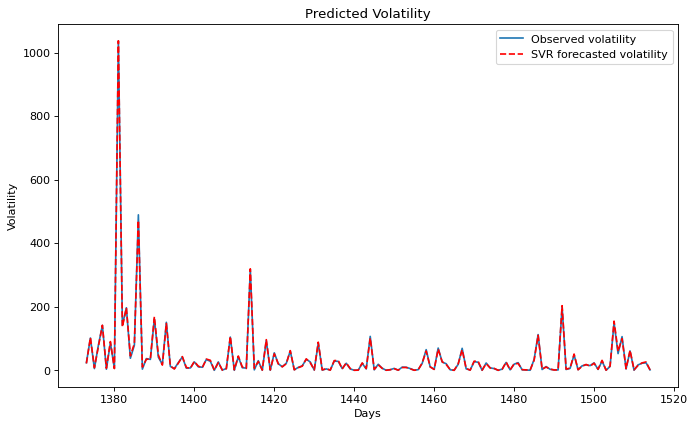

In [ ]:
#ETH Volatility Pandemic Linear
y_pred_vol_eth,model_vol_eth = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'linear',0.9819586596301351,C=0.5045499928354602)#current best


In [ ]:
# param_eth_v=sigopt(X_sg,np.squeeze(y_sg),'rbf','ETH Volatility Normal RBF',observation_budget=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[669403.67033935 187513.70875671]]
b koef: [207.94767784] 

Train score: 0.26458336774362723
Test score: 0.7574736007054512 

MSE: 2598.374437916196
MAE: 6.683882499709358
RMSE: 50.97425269600522
AIC 1120.495066345798
BIC 1126.4067204610005 

Statistika Deskriptif Data Populasi
Skewness [7.04599328]
Kurtosis [60.1927653]
Mean vol_prox_shift1    40.903049
dtype: float64
STD vol_prox_shift1    103.873789
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 3.8356253649940046
Kurtosis 17.495669885632665
Mean 35.92051969920387
STD 65.92898843187038
None


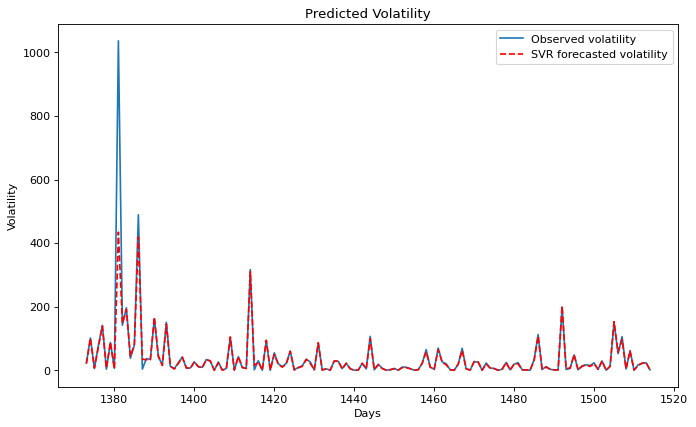

In [ ]:
#ETH Volatility Pandemic RBF
y_pred_vol_eth,model_vol_eth = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'rbf',0.1654152443099705,C=100,gamma=1.5157482877236102e-06)#current best

In [ ]:
# param_eth_v=sigopt(X_sg,np.squeeze(y_sg),'poly','ETH Volatility Pandemic Poly',observation_budget=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[0.99141098 0.01235722]]
b koef: [-0.21320635] 

Train score: 0.9998358317692293
Test score: 0.9992710797128163 

MSE: 7.809491449202675
MAE: 1.8292604739400555
RMSE: 2.794546734123921
AIC 295.8582581877397
BIC 301.7699123029422 

Statistika Deskriptif Data Populasi
Skewness [7.04599328]
Kurtosis [60.1927653]
Mean vol_prox_shift1    40.903049
dtype: float64
STD vol_prox_shift1    103.873789
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 7.0846364623505
Kurtosis 61.03653015359039
Mean 40.96078660313535
STD 103.02171718353944
None


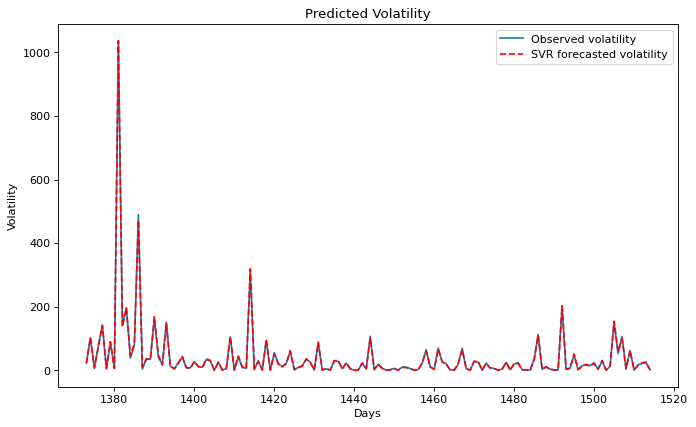

In [ ]:
#ETH Volatility Pandemic Poly
y_pred_vol_eth_pandemic_poly,model_vol_eth = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'poly',0.3129784496014994,C=0.00044639910055377217,gamma=22.23342964850016,degree=1)#current best

In [ ]:
# interactive_plot(df_eth,df_sg_eth,y_sg_val,y_pred_vol_eth)

Jarque-Bera Test
H0: Goodness of fit of the sample data for normality distribution 

JB Stat Test: 3102.12552246869
JB P-val: 0.0
H0 ditolak, sehingga data tidak berdistribusi normal.
Dengan begitu data terindikasi memiliki distribusi ekor tebal


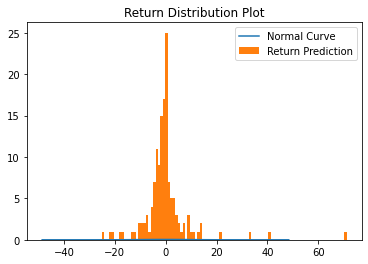

In [ ]:
# Statistik Property
return_pred_eth = vol_return(y_pred_vol_eth)
jb_test(return_pred_eth,0.01)
normal_plot(return_pred_eth)

## SVR based GARCH (Tether)

In [ ]:
#Step I: SVR-based AR(1) models for return
n_test = m.floor(len(df_tether_p)/4)
print('n test: ',n_test)
X = df_tether_p[['Return']].iloc[:-n_test]
y = df_tether_p['Return'].shift(-1).iloc[:-n_test]
X_val = df_tether_p[['Return']].iloc[-n_test:-1]
y_val = df_tether_p['Return'].shift(-1).iloc[-n_test:-1]

n test:  143


In [ ]:
#bayes-opt
# score,param_tehter_r =bayesopt(X,y)

In [ ]:
# print(score)
# print(param_tehter_r)

w koef: [[-0.41540923]]
b koef: [0.00244838] 

Train score: 0.20419063349645394
Test score: 0.10279230160614872 

MSE: 0.0018518816456364266
MAE: 0.03227662836590744
RMSE: 0.0430334944622956
AIC -889.4005332482581
BIC -883.4888791330555 

Statistika Deskriptif Data Populasi
Skewness 0.1456520240194621
Kurtosis 0.8228172768999595
Mean 0.0001323813999254428
STD 0.04559263931796198
None
Statistika Deskriptif Prediksi
Skewness -0.14733384204896746
Kurtosis 0.8199533603868554
Mean 0.002405949777293439
STD 0.018876934359894564
None


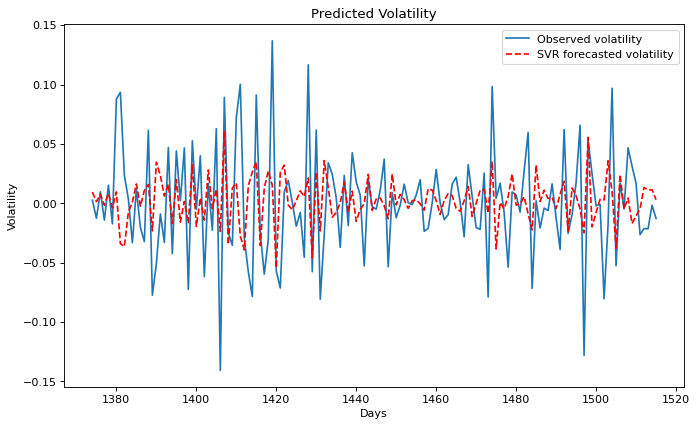

In [ ]:
#Tether Return
y_pred_tether,model_r_tether = svr2(X,y,X_val,y_val,'linear',0.07000504937614355,C=96.88654676507419)
# y_pred_tether,model_r_tether = svr(X,y,X_val,y_val,param_tehter_r)
#sebenernya matriks penilaiannya di Step I ga penting
#yg dicari cuman nilai u 

u_tether =y- model_r_tether.predict(X) 
u_tether_pred_pandemic= y_val-y_pred_tether #return error
u2 = u_tether**2
u2_pred = u_tether_pred_pandemic**2

In [ ]:
df_sg_tether = pd.DataFrame(u2.append(u2_pred))
df_sg_tether.rename(columns={'Return':'u2'},inplace=True)
df_sg_tether['vol_prox']=(df_tether_p['Return'].iloc[:-1]-df_tether_p['Return'].iloc[:-1].mean())**2
X_sg,y_sg,X_sg_val,y_sg_val = garch_df(df_sg_tether,1,1)
print('X columns: ',X_sg.columns)
print('y columns: ',y_sg.columns)

X columns:  Index(['u2', 'vol_prox'], dtype='object')
y columns:  Index(['vol_prox_shift1'], dtype='object')


In [ ]:
#bayes-opt
# score,param_tehter_v =bayesopt2(X_sg,y_sg)

In [ ]:
# print(score)
# print(param_tehter_v)

In [ ]:
#Sigopt Tether Pandemic Linear
# param_tether_v=sigopt(X_sg,np.squeeze(y_sg),'linear','Tether Volatility Pandemic Linear',observation_budget=100)

w koef: [[1.07801057 0.04021365]]
b koef: [0.00123316] 

Train score: 0.8140692364089617
Test score: 0.5461194966211822 

MSE: 5.470823272682958e-06
MAE: 0.0017619265479904545
RMSE: 0.0023389791090736483
AIC -1716.4835653272269
BIC -1710.5719112120244 

Statistika Deskriptif Data Populasi
Skewness [2.85361469]
Kurtosis [9.31096369]
Mean vol_prox_shift1    0.002065
dtype: float64
STD vol_prox_shift1    0.003484
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 2.814060344771211
Kurtosis 8.31166522698354
Mean 0.0033126646905187514
STD 0.003421466303342452
None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



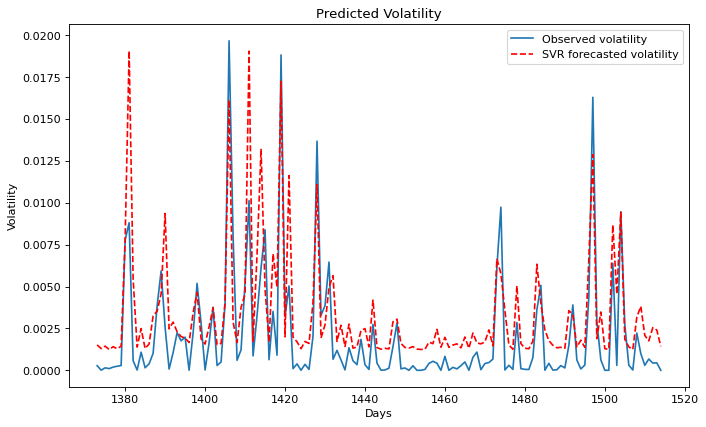

In [ ]:
#Tether Volatility Pandemic Linear
y_pred_vol_tether,model_v_tether = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'linear',
                                        0.819259894419074,C=6.945725097702327) 

In [ ]:
#Sigopt Tether Pandemic RBF
# param_tether_v=sigopt(X_sg,np.squeeze(y_sg),'rbf','Tether Volatility Pandemic RBF',observation_budget=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[700.68368331 212.28452567]]
b koef: [8.47590503] 

Train score: 0.9958911121317747
Test score: 0.671518120082232 

MSE: 3.959337975372136e-06
MAE: 0.001183035145596054
RMSE: 0.0019898085273141576
AIC -1762.3995888946204
BIC -1756.4879347794179 

Statistika Deskriptif Data Populasi
Skewness [2.85361469]
Kurtosis [9.31096369]
Mean vol_prox_shift1    0.002065
dtype: float64
STD vol_prox_shift1    0.003484
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 2.5318110783177015
Kurtosis 7.137953072053827
Mean 0.0021500560314106406
STD 0.003436134765997429
None


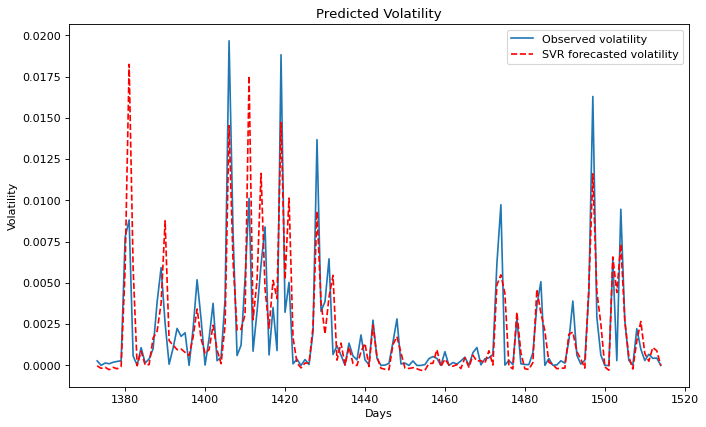

In [ ]:
#Tether Volatility Pandemic RBF
y_pred_vol_tether_pandemic_rbf,model_v_tether = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'rbf',1e-08,C=100,gamma=0.10259296312215563) #grid search


In [ ]:
#Sigopt Tether Pandemic Poly
# param_tether_v=sigopt(X_sg,np.squeeze(y_sg),'poly','Tether Volatility Pandemic Poly',observation_budget=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



w koef: [[ 1.04801138 -0.015435  ]]
b koef: [0.00065651] 

Train score: 0.7851613519811824
Test score: 0.6498131634635156 

MSE: 4.220957456531347e-06
MAE: 0.0013937019695629568
RMSE: 0.002054496886473997
AIC -1753.313696970813
BIC -1747.4020428556105 

Statistika Deskriptif Data Populasi
Skewness [2.85361469]
Kurtosis [9.31096369]
Mean vol_prox_shift1    0.002065
dtype: float64
STD vol_prox_shift1    0.003484
dtype: float64
None
Statistika Deskriptif Prediksi
Skewness 2.8071975409703724
Kurtosis 8.232495515288909
Mean 0.0025654986300829297
STD 0.003298890289619717
None


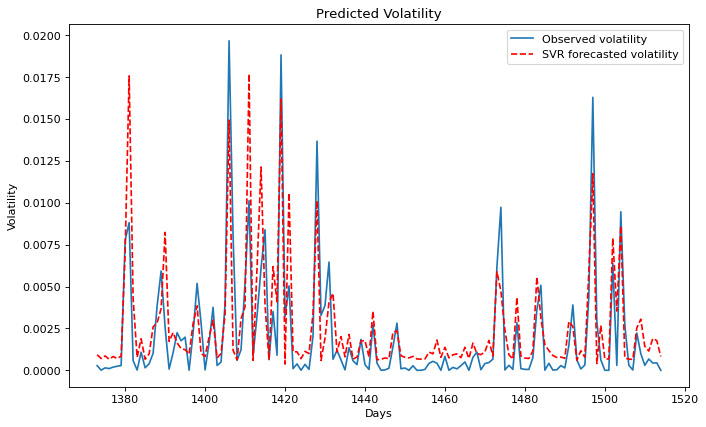

In [ ]:
#Tether Volatility Pandemic Poly
y_pred_vol_tether,model_v_tether = svr2(X_sg,y_sg,X_sg_val,y_sg_val,'poly',
                                        1e-08,C=100,degree=1) #grid search


In [ ]:
# interactive_plot(df_tether,df_sg_tether,y_sg_val,y_pred_vol_tether)

Jarque-Bera Test
H0: Goodness of fit of the sample data for normality distribution 

JB Stat Test: 577.86004411254
JB P-val: 0.0
H0 ditolak, sehingga data tidak berdistribusi normal.
Dengan begitu data terindikasi memiliki distribusi ekor tebal


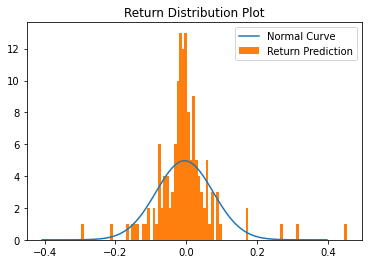

In [ ]:
# Statistik Property
return_pred_tether = vol_return(y_pred_vol_tether)
jb_test(return_pred_tether,0.01)
normal_plot(return_pred_tether)

## SVR based GARCH (BNB)

In [ ]:
#Step I: SVR-based AR(1) models for return
n_test = m.floor(len(df_bnb_p)/4)
print('n test: ',n_test)
X = df_bnb_p[['Return']].iloc[:-n_test]
y = df_bnb_p['Return'].shift(-1).iloc[:-n_test]
X_val = df_bnb_p[['Return']].iloc[-n_test:-1]
y_val = df_bnb_p['Return'].shift(-1).iloc[-n_test:-1]

n test:  143


In [ ]:
#bayes-opt
# score,param_bnb_r =bayesopt(X,y)

In [ ]:
# print(score)
# print(param_bnb_r)
# [('C', 1e-08), ('degree', 1), ('epsilon', 1.0), ('gamma', 100.0), ('kernel', 'linear')])

w koef: [[-0.21044572]]
b koef: [0.67808724] 

Train score: -0.010051395662745044
Test score: -0.01110283251610289 

MSE: 50.23350340331515
MAE: 4.713841116484141
RMSE: 7.087559763650332
AIC 560.1688727633465
BIC 566.080526878549 

Statistika Deskriptif Data Populasi
Skewness -1.2306489911117506
Kurtosis 8.177168457757654
Mean -0.3888607555440612
STD 7.073489062313892
None
Statistika Deskriptif Prediksi
Skewness 1.2277018008298302
Kurtosis 8.139055783807478
Mean 0.7580875726210947
STD 1.4849092062920446
None


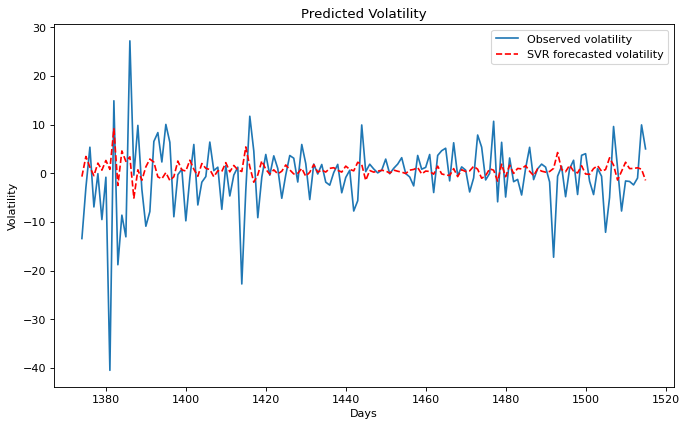

In [ ]:
#BNB Return
y_pred_bnb,model_r_bnb = svr2(X,y,X_val,y_val,'linear',0.00276458451365657,C=74.50852057148509)
# y_pred_gold,model_r_gold = svr(X,y,X_val,y_val,param_g_r)
#sebenernya matriks penilaiannya di Step I ga penting
#yg dicari cuman nilai u 

u_bnb =y- model_r_bnb.predict(X) 
u_bnb_pred_pandemic= y_val-y_pred_bnb #return error
u2 = u_bnb**2
u2_pred = u_bnb_pred_pandemic**2

In [ ]:
df_sg_bnb = pd.DataFrame(u2.append(u2_pred))
df_sg_bnb.rename(columns={'Return':'u2'},inplace=True)
df_sg_bnb['vol_prox']=(df_bnb_p['Return'].iloc[:-1]-df_bnb_p['Return'].iloc[:-1].mean())**2
X_sg,y_sg,X_sg_val,y_sg_val = garch_df(df_sg_bnb,1,1)
print('X columns: ',X_sg.columns)
print('y columns: ',y_sg.columns)

X columns:  Index(['u2', 'vol_prox'], dtype='object')
y columns:  Index(['vol_prox_shift1'], dtype='object')


In [ ]:
#bayes-opt
# score,param_g_v =bayesopt2(X_sg,y_sg)

In [ ]:
# print(score)
# print(param_g_v)

In [ ]:
#Sigopt BNB Volatility Pandemic Linear
# param_bnb_v=sigopt(X_sg,np.squeeze(y_sg),'linear','BNB Volatility Pandemic Linear',observation_budget=100)

w koef: [[0.8957515  0.03529362]]
b koef: [0.63433605] 

Train score: 0.9797449112437085
Test score: 0.9659803883222137 

MSE: 912.8401922804338
MAE: 13.00608294080127
RMSE: 30.213245311956044
AIC 971.9516377800521
BIC 977.8632918952546 

Statistika Deskriptif Data Populasi
Skewness 7.6434478689456204
Kurtosis 68.16890962388678
Mean 50.58556555218177
STD 164.38694206407015
None
Statistika Deskriptif Prediksi
Skewness 8.104929475465749
Kurtosis 76.55096076903183
Mean 47.27051828122308
STD 144.252343700088
None


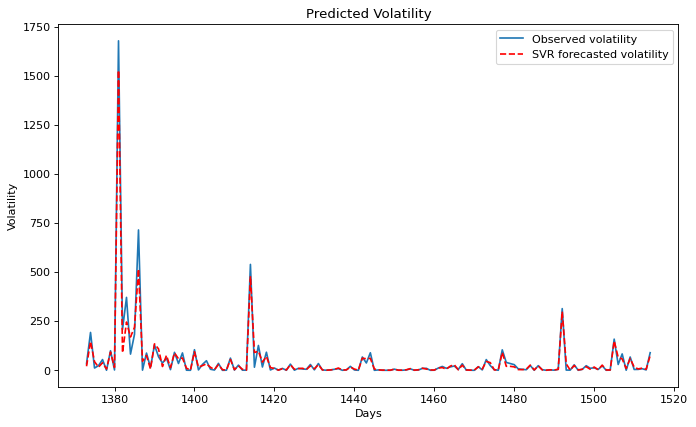

In [ ]:
#BNB Volatility Pandemic Linear
y_pred_vol_bnb,model_v_bnb = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),'linear',1,C=100)


In [ ]:
#Sigopt Volatility Pandemic RBF
# param_bnb_v=sigopt(X_sg,np.squeeze(y_sg),'rbf','BNB Volatility Pandemic RBF',observation_budget=100)

w koef: [[1016077.00821597   -9815.22466552]]
b koef: [308.04597805] 

Train score: 0.38203432406573445
Test score: 0.5302008771209308 

MSE: 12606.008725906015
MAE: 22.281308893350065
RMSE: 112.27648340550222
AIC 1344.7538984431096
BIC 1350.6655525583121 

Statistika Deskriptif Data Populasi
Skewness 7.6434478689456204
Kurtosis 68.16890962388678
Mean 50.58556555218177
STD 164.38694206407015
None
Statistika Deskriptif Prediksi
Skewness 3.5597182037755255
Kurtosis 13.652244690397083
Mean 38.726551676877705
STD 77.83373549041761
None


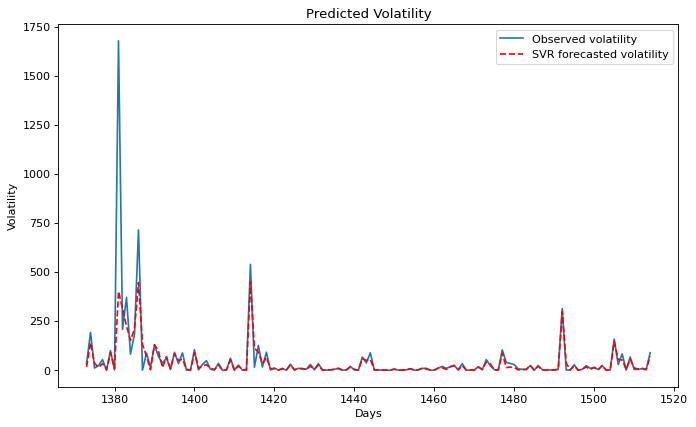

In [ ]:
#BNB Volatility Pandemic RBF
# y_pred_vol_bnb,model_v_bnb = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),
#                                   'rbf',0.9781664810816094,C=100,
#                                   gamma=1.5839377207012832e-06)
y_pred_vol_bnb,model_v_bnb = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),
                                  'rbf',0.8505553519323665,C=100,
                                  gamma=1.4072354067718672e-06)

In [ ]:
#Sigopt BNB Pandemic Poly
# param_bnb_v=sigopt(X_sg,np.squeeze(y_sg),'poly','BNB Volatility Pandemic Poly',observation_budget=100)

w koef: [[0.89929188 0.04275383]]
b koef: [0.28874502] 

Train score: 0.9805504790444514
Test score: 0.9670874956149211 

MSE: 883.1334441987062
MAE: 12.944390992233997
RMSE: 29.717561208798852
AIC 967.253636746818
BIC 973.1652908620205 

Statistika Deskriptif Data Populasi
Skewness 7.6434478689456204
Kurtosis 68.16890962388678
Mean 50.58556555218177
STD 164.38694206407015
None
Statistika Deskriptif Prediksi
Skewness 8.086425449177396
Kurtosis 76.29263033764374
Mean 47.476395394166744
STD 144.90877504711162
None


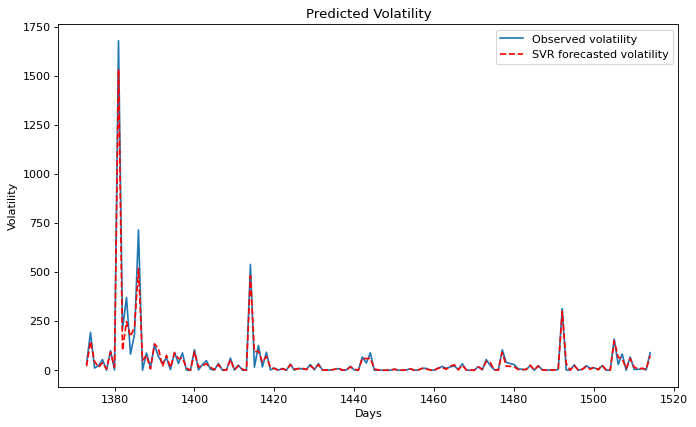

In [ ]:
#BNB Volatility Pandemic Poly
y_pred_vol_bnb_pandemic_poly,model_v_bnb = svr2(X_sg,np.squeeze(y_sg),X_sg_val,np.squeeze(y_sg_val),
                                  'poly',0.2546503173925034,C=15.614243480804685,
                                  degree=1)

In [ ]:
#Nilai gamma BNB Pandemic Poly
print(model_v_bnb)
#cari yang gamma=...

SVR(C=15.614243480804685, degree=1, epsilon=0.2546503173925034, gamma=3,
    kernel='poly')


In [ ]:
# interactive_plot(df_g,df_sg_g,y_sg_val,y_pred_vol_gold)

In [ ]:
# Statistik Property
# return_pred_gold = vol_return(y_pred_vol_bnb)
# jb_test(return_pred_bnb,0.01)
# normal_plot(return_pred_bnb)

# VaR

## Normal

In [ ]:
z_hat_btc_n = (df_n['Return'][u_btc_pred_normal[:-1].index]-u_btc_pred_normal[:-1])/np.sqrt(y_pred_vol_btc_normal_linear[:-1])
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_btc_n)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_btc_n)[n_f-1])+(r*np.sort(z_hat_btc_n)[n_c-1])
  globals()['var_btc_n_%s' % int(i*100)] = u_btc_pred_normal[-1:].values+np.sqrt(y_pred_vol_btc_normal_linear[-1])*q
  print('BTC Var({}%): {}'.format(i*100, globals()['var_btc_n_%s' % int(i*100)]))
print('\n')

z_hat_eth_n = (df_eth_n['Return'][u_eth_pred_normal[:-1].index]-u_eth_pred_normal[:-1])/np.sqrt(y_pred_vol_eth_normal_linear[:-1])
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_eth_n)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_eth_n)[n_f-1])+(r*np.sort(z_hat_eth_n)[n_c-1])
  globals()['var_eth_n_%s' % int(i*100)] = u_eth_pred_normal[-1:].values+np.sqrt(abs(y_pred_vol_eth_normal_linear[-1]))*q
  print('ETH Var({}%): {}'.format(i*100, globals()['var_eth_n_%s' % int(i*100)]))
print('\n')

z_hat_tether_n = (df_tether_n['Return'][u_tether_pred_normal[:-1].index]-u_tether_pred_normal[:-1])/np.sqrt(abs(y_pred_vol_tether_normal_poly[:-1]))
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_tether_n)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_tether_n)[n_f-1])+(r*np.sort(z_hat_tether_n)[n_c-1])
  globals()['var_tether_n_%s' % int(i*100)] = u_tether_pred_normal[-1:].values+np.sqrt(abs(y_pred_vol_tether_normal_poly)[-1])*q
  print('Tether Var({}%): {}'.format(i*100, globals()['var_tether_n_%s' % int(i*100)]))
print('\n')

z_hat_bnb_n = (df_bnb_n['Return'][u_bnb_pred_normal[:-1].index]-u_bnb_pred_normal[:-1])/np.sqrt(y_pred_vol_bnb_normal_linear[:-1])
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_bnb_n)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_bnb_n)[n_f-1])+(r*np.sort(z_hat_bnb_n)[n_c-1])
  globals()['var_bnb_n_%s' % int(i*100)] = u_bnb_pred_normal[-1:].values+np.sqrt(y_pred_vol_bnb_normal_linear[-1])*q
  print('BNB Var({}%): {}'.format(i*100, globals()['var_bnb_n_%s' % int(i*100)]))
print('\n')

BTC Var(10.0%): [-9.64414121]
BTC Var(5.0%): [-15.98379007]
BTC Var(1.0%): [-30.54636339]


ETH Var(10.0%): [-19.35631248]
ETH Var(5.0%): [-30.37564987]
ETH Var(1.0%): [-57.29831283]


Tether Var(10.0%): [-0.9936132]
Tether Var(5.0%): [-1.55717482]
Tether Var(1.0%): [-6.21182521]


BNB Var(10.0%): [-12.29457022]
BNB Var(5.0%): [-16.68667639]
BNB Var(1.0%): [-41.86039452]




## Pandemic

In [ ]:
z_hat_btc_p = (df_p['Return'][u_btc_pred_pandemic[:-1].index]-u_btc_pred_pandemic[:-1])/np.sqrt(abs(y_pred_vol_btc_pandemic_linear[:-1]))
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_btc_p)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_btc_p)[n_f-1])+(r*np.sort(z_hat_btc_p)[n_c-1])
  globals()['var_btc_p_%s' % int(i*100)] = u_btc_pred_pandemic[-1:].values+np.sqrt(abs(y_pred_vol_btc_pandemic_linear)[-1])*q
  print('BTC Var({}%): {}'.format(i*100, globals()['var_btc_p_%s' % int(i*100)]))
print('\n')

z_hat_eth_p = (df_eth_p['Return'][u_eth_pred_pandemic[:-1].index]-u_eth_pred_pandemic[:-1])/np.sqrt(abs(y_pred_vol_eth_pandemic_poly[:-1]))
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_eth_p)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_eth_p)[n_f-1])+(r*np.sort(z_hat_eth_p)[n_c-1])
  globals()['var_eth_p_%s' % int(i*100)] = u_eth_pred_pandemic[-1:].values+np.sqrt(abs(abs(y_pred_vol_eth_pandemic_poly)[-1]))*q
  print('ETH Var({}%): {}'.format(i*100, globals()['var_eth_p_%s' % int(i*100)]))
print('\n')

z_hat_tether_p = (df_tether_p['Return'][u_tether_pred_pandemic[:-1].index]-u_tether_pred_pandemic[:-1])/np.sqrt(abs(y_pred_vol_tether_pandemic_rbf[:-1]))
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_tether_p)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_tether_p)[n_f-1])+(r*np.sort(z_hat_tether_p)[n_c-1])
  globals()['var_tether_p_%s' % int(i*100)] = u_tether_pred_pandemic[-1:].values+np.sqrt(abs(y_pred_vol_tether_pandemic_rbf)[-1])*q
  print('Tether Var({}%): {}'.format(i*100, globals()['var_tether_p_%s' % int(i*100)]))
print('\n')

z_hat_bnb_p = (df_bnb_p['Return'][u_bnb_pred_pandemic[:-1].index]-u_bnb_pred_pandemic[:-1])/np.sqrt(y_pred_vol_bnb_pandemic_poly[:-1])
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_bnb_p)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_bnb_p)[n_f-1])+(r*np.sort(z_hat_bnb_p)[n_c-1])
  globals()['var_bnb_p_%s' % int(i*100)] = u_bnb_pred_pandemic[-1:].values+np.sqrt(y_pred_vol_bnb_pandemic_poly[-1])*q
  print('BNB Var({}%): {}'.format(i*100, globals()['var_bnb_p_%s' % int(i*100)]))
print('\n')

BTC Var(10.0%): [3.63022945]
BTC Var(5.0%): [2.99423275]
BTC Var(1.0%): [-1.13983976]


ETH Var(10.0%): [2.19231698]
ETH Var(5.0%): [0.97523569]
ETH Var(1.0%): [-5.42341086]


Tether Var(10.0%): [-0.02089321]
Tether Var(5.0%): [-0.02353138]
Tether Var(1.0%): [-0.05805637]


BNB Var(10.0%): [-8.83161084]
BNB Var(5.0%): [-21.09770966]
BNB Var(1.0%): [-50.01082986]




# CVaR

## Normal

In [ ]:
import random
from tqdm import tqdm
return_gen_btc_n=[]
return_gen_eth_n=[]
return_gen_tether_n=[]
return_gen_bnb_n=[]
for i in tqdm(range(10000)):
  return_gen_btc_n.append(u_btc_pred_normal[-1:].values+np.sqrt(abs(y_pred_vol_btc_normal_linear)[-1])*random.choice(z_hat_btc_n.reset_index()['Return']))
  return_gen_eth_n.append(u_eth_pred_normal[-1:].values+np.sqrt(abs(y_pred_vol_eth_normal_linear)[-1])*random.choice(z_hat_eth_n.reset_index()['Return']))
  return_gen_tether_n.append(u_tether_pred_normal[-1:].values+np.sqrt(abs(y_pred_vol_tether_normal_poly)[-1])*random.choice(z_hat_tether_n.reset_index()['Return']))
  return_gen_bnb_n.append(u_bnb_pred_normal[-1:].values+np.sqrt(abs(y_pred_vol_bnb_normal_linear)[-1])*random.choice(z_hat_bnb_n.reset_index()['Return']))

100%|██████████| 10000/10000 [00:42<00:00, 236.00it/s]


In [ ]:
for i in ([10,5,1]):
  globals()['cvar_btc_n_%s' % int(i)]=len([x for x in return_gen_btc_n if x < globals()['var_btc_n_%s' % int(i)]])/10000
  print('BTC CVar({}%): {}%'.format(i, globals()['cvar_btc_n_%s' % int(i)]*100))
print('\n')
for i in ([10,5,1]):  
  globals()['cvar_eth_n_%s' % int(i)]=len([x for x in return_gen_eth_n if x < globals()['var_eth_n_%s' % int(i)]])/10000
  print('ETH CVar({}%): {}%'.format(i, globals()['cvar_eth_n_%s' % int(i)]*100))
print('\n')
for i in ([10,5,1]):
  globals()['cvar_tether_n_%s' % int(i)]=len([x for x in return_gen_tether_n if x < globals()['var_tether_n_%s' % int(i)]])/10000
  print('Tether CVar({}%): {}%'.format(i, globals()['cvar_tether_n_%s' % int(i)]*100))
print('\n')
for i in ([10,5,1]):
  globals()['cvar_bnb_n_%s' % int(i)]=len([x for x in return_gen_bnb_n if x < globals()['var_bnb_n_%s' % int(i)]])/10000
  print('BNB CVar({}%): {}%'.format(i, round(globals()['cvar_bnb_n_%s' % int(i)]*100,2)))


BTC CVar(10%): 9.76%
BTC CVar(5%): 4.390000000000001%
BTC CVar(1%): 0.62%


ETH CVar(10%): 10.11%
ETH CVar(5%): 4.89%
ETH CVar(1%): 1.0%


Tether CVar(10%): 9.73%
Tether CVar(5%): 4.77%
Tether CVar(1%): 0.86%


BNB CVar(10%): 9.44%
BNB CVar(5%): 4.59%
BNB CVar(1%): 0.73%


## Pandemic

In [ ]:
import random
return_gen_btc_p=[]
return_gen_eth_p=[]
return_gen_tether_p=[]
return_gen_bnb_p=[]
for i in tqdm(range(10000)):
  return_gen_btc_p.append(u_btc_pred_pandemic[-1:].values+np.sqrt(abs(y_pred_vol_btc_pandemic_linear)[-1])*random.choice(z_hat_btc_p.reset_index()['Return']))
  return_gen_eth_p.append(u_eth_pred_pandemic[-1:].values+np.sqrt(abs(y_pred_vol_eth_pandemic_poly)[-1])*random.choice(z_hat_eth_p.reset_index()['Return']))
  return_gen_tether_p.append(u_tether_pred_pandemic[-1:].values+np.sqrt(abs(y_pred_vol_tether_pandemic_rbf)[-1])*random.choice(z_hat_tether_p.reset_index()['Return']))
  return_gen_bnb_p.append(u_bnb_pred_pandemic[-1:].values+np.sqrt(abs(y_pred_vol_bnb_pandemic_poly)[-1])*random.choice(z_hat_bnb_p.reset_index()['Return']))

100%|██████████| 10000/10000 [00:42<00:00, 237.05it/s]


In [ ]:
for i in ([10,5,1]):
  globals()['cvar_btc_p_%s' % int(i)]=len([x for x in return_gen_btc_p if x < globals()['var_btc_p_%s' % int(i)]])/10000
  print('BTC CVar({}%): {}%'.format(i, globals()['cvar_btc_p_%s' % int(i)]*100))
print('\n')
for i in ([10,5,1]):  
  globals()['cvar_eth_p_%s' % int(i)]=len([x for x in return_gen_eth_p if x < globals()['var_eth_p_%s' % int(i)]])/10000
  print('ETH CVar({}%): {}%'.format(i, round(globals()['cvar_eth_p_%s' % int(i)]*100,2)))
print('\n')
for i in ([10,5,1]):
  globals()['cvar_tether_p_%s' % int(i)]=len([x for x in return_gen_tether_p if x < globals()['var_tether_p_%s' % int(i)]])/10000
  print('Tether CVar({}%): {}%'.format(i, globals()['cvar_tether_p_%s' % int(i)]*100))
print('\n')
for i in ([10,5,1]):
  globals()['cvar_bnb_p_%s' % int(i)]=len([x for x in return_gen_bnb_p if x < globals()['var_bnb_p_%s' % int(i)]])/10000
  print('BNB CVar({}%): {}%'.format(i, globals()['cvar_bnb_p_%s' % int(i)]*100))


BTC CVar(10%): 10.42%
BTC CVar(5%): 5.17%
BTC CVar(1%): 0.77%


ETH CVar(10%): 9.51%
ETH CVar(5%): 4.88%
ETH CVar(1%): 0.58%


Tether CVar(10%): 10.0%
Tether CVar(5%): 5.140000000000001%
Tether CVar(1%): 0.8%


BNB CVar(10%): 9.969999999999999%
BNB CVar(5%): 5.07%
BNB CVar(1%): 0.66%


# ES

## Normal

In [ ]:
z_hat_btc_n = (df_n['Return'][u_btc_pred_normal[:-1].index]-u_btc_pred_normal[:-1])/np.sqrt(y_pred_vol_btc_normal_linear[:-1])
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_btc_n)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_btc_n)[n_f-1])+(r*np.sort(z_hat_btc_n)[n_c-1])
  es_z = np.mean([x for x in z_hat_btc_n if x < q])
  globals()['es_btc_n_%s' % int(i*100)] = u_btc_pred_normal[-1:].values+np.sqrt(y_pred_vol_btc_normal_linear[-1])*es_z
  print('BTC ES({}%): {}'.format(i*100, globals()['es_btc_n_%s' % int(i*100)]))
print('\n')

z_hat_eth_n = (df_eth_n['Return'][u_eth_pred_normal[:-1].index]-u_eth_pred_normal[:-1])/np.sqrt(y_pred_vol_eth_normal_linear[:-1])
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_eth_n)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_eth_n)[n_f-1])+(r*np.sort(z_hat_eth_n)[n_c-1])
  es_z = np.mean([x for x in z_hat_eth_n if x < q])
  globals()['es_eth_n_%s' % int(i*100)] = u_eth_pred_normal[-1:].values+np.sqrt(abs(y_pred_vol_eth_normal_linear[-1]))*es_z
  print('ETH Var({}%): {}'.format(i*100, globals()['es_eth_n_%s' % int(i*100)]))
print('\n')

z_hat_tether_n = (df_tether_n['Return'][u_tether_pred_normal[:-1].index]-u_tether_pred_normal[:-1])/np.sqrt(abs(y_pred_vol_tether_normal_poly[:-1]))
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_tether_n)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_tether_n)[n_f-1])+(r*np.sort(z_hat_tether_n)[n_c-1])
  es_z = np.mean([x for x in z_hat_tether_n if x < q])
  globals()['es_tether_n_%s' % int(i*100)] = u_tether_pred_normal[-1:].values+np.sqrt(abs(y_pred_vol_tether_normal_poly)[-1])*es_z
  print('Tether ES({}%): {}'.format(i*100, globals()['es_tether_n_%s' % int(i*100)]))
print('\n')

z_hat_bnb_n = (df_bnb_n['Return'][u_bnb_pred_normal[:-1].index]-u_bnb_pred_normal[:-1])/np.sqrt(y_pred_vol_bnb_normal_linear[:-1])
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_bnb_n)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_bnb_n)[n_f-1])+(r*np.sort(z_hat_bnb_n)[n_c-1])
  es_z = np.mean([x for x in z_hat_bnb_n if x < q])
  globals()['es_bnb_n_%s' % int(i*100)] = u_bnb_pred_normal[-1:].values+np.sqrt(y_pred_vol_bnb_normal_linear[-1])*es_z
  print('BNB ES({}%): {}'.format(i*100, globals()['es_bnb_n_%s' % int(i*100)]))
print('\n')

BTC ES(10.0%): [-19.06885683]
BTC ES(5.0%): [-26.2182678]
BTC ES(1.0%): [-51.44950377]


ETH Var(10.0%): [-34.19327998]
ETH Var(5.0%): [-45.80585086]
ETH Var(1.0%): [-75.07638838]


Tether ES(10.0%): [-2.92554024]
Tether ES(5.0%): [-4.79705104]
Tether ES(1.0%): [-15.63064879]


BNB ES(10.0%): [-23.43510075]
BNB ES(5.0%): [-33.3068804]
BNB ES(1.0%): [-57.0830631]




In [ ]:
# coins = ['btc','eth','tether','bnb']
# df_btc_n = df_n.copy()
# df_btc_p = df_p.copy()

# for coin in coins:
#   for i in (1,5,10):
#     #mengambil index" yang kurang dari VaR
#     ind_dummy = globals()['df_%s_n' % (coin)].loc[globals()['df_%s_n' % (coin)]['Return']<globals()['var_'+coin+'_n'+'_%s' % i][0]]['Return'].index 
#     #menghitung banyak index yang kurang dari VaR namun dalam data test
#     len_ind=len([x for x in ind_dummy if x>= u_btc_pred_normal.index[0]])
#     globals()['es_'+coin+'_n'+'_%s' % i]=globals()['df_%s_n' % (coin)].loc[globals()['df_%s_n' % (coin)]['Return']<globals()['var_'+coin+'_n'+'_%s' % i][0]]['Return'][-len_ind:].mean()
#     print(coin.upper()+' '+'Normal'+' ES ({})%: {}'.format(i,globals()['es_'+coin+'_n'+'_%s' % i]))   
#   print('\n')


## Pandemic

In [ ]:
z_hat_btc_p = (df_p['Return'][u_btc_pred_pandemic[:-1].index]-u_btc_pred_pandemic[:-1])/np.sqrt(abs(y_pred_vol_btc_pandemic_linear[:-1]))
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_btc_p)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_btc_p)[n_f-1])+(r*np.sort(z_hat_btc_p)[n_c-1])
  es_z = np.mean([x for x in z_hat_btc_p if x < q])
  globals()['es_btc_p_%s' % int(i*100)] = u_btc_pred_pandemic[-1:].values+np.sqrt(abs(y_pred_vol_btc_pandemic_linear)[-1])*es_z
  print('BTC ES({}%): {}'.format(i*100, globals()['es_btc_p_%s' % int(i*100)]))
print('\n')

z_hat_eth_p = (df_eth_p['Return'][u_eth_pred_pandemic[:-1].index]-u_eth_pred_pandemic[:-1])/np.sqrt(abs(y_pred_vol_eth_pandemic_poly[:-1]))
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_eth_p)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_eth_p)[n_f-1])+(r*np.sort(z_hat_eth_p)[n_c-1])
  es_z = np.mean([x for x in z_hat_eth_p if x < q])
  globals()['es_eth_p_%s' % int(i*100)] = u_eth_pred_pandemic[-1:].values+np.sqrt(abs(abs(y_pred_vol_eth_pandemic_poly)[-1]))*es_z
  print('ETH ES({}%): {}'.format(i*100, globals()['es_eth_p_%s' % int(i*100)]))
print('\n')

z_hat_tether_p = (df_tether_p['Return'][u_tether_pred_pandemic[:-1].index]-u_tether_pred_pandemic[:-1])/np.sqrt(abs(y_pred_vol_tether_pandemic_rbf[:-1]))
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_tether_p)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_tether_p)[n_f-1])+(r*np.sort(z_hat_tether_p)[n_c-1])
  es_z = np.mean([x for x in z_hat_tether_p if x < q])
  globals()['es_tether_p_%s' % int(i*100)] = u_tether_pred_pandemic[-1:].values+np.sqrt(abs(y_pred_vol_tether_pandemic_rbf)[-1])*es_z
  print('Tether ES({}%): {}'.format(i*100, globals()['es_tether_p_%s' % int(i*100)]))
print('\n')

z_hat_bnb_p = (df_bnb_p['Return'][u_bnb_pred_pandemic[:-1].index]-u_bnb_pred_pandemic[:-1])/np.sqrt(y_pred_vol_bnb_pandemic_poly[:-1])
for i in ([0.1,0.05,0.01]):
  n = (len(z_hat_bnb_p)+1)*i
  n_f = m.floor(n)
  n_c = m.ceil(n)
  r = n_c-n
  q = ((1-r)*np.sort(z_hat_bnb_p)[n_f-1])+(r*np.sort(z_hat_bnb_p)[n_c-1])
  es_z = np.mean([x for x in z_hat_bnb_p if x < q])
  globals()['es_bnb_p_%s' % int(i*100)] = u_bnb_pred_pandemic[-1:].values+np.sqrt(y_pred_vol_bnb_pandemic_poly[-1])*es_z
  print('BNB ES({}%): {}'.format(i*100, globals()['es_bnb_p_%s' % int(i*100)]))
print('\n')

BTC ES(10.0%): [2.17170942]
BTC ES(5.0%): [1.04882789]
BTC ES(1.0%): [-1.23609166]


ETH ES(10.0%): [-0.37838174]
ETH ES(5.0%): [-2.14440234]
ETH ES(1.0%): [-5.94550589]


Tether ES(10.0%): [-0.02894883]
Tether ES(5.0%): [-0.03612276]
Tether ES(1.0%): [-0.06943842]


BNB ES(10.0%): [-24.09757951]
BNB ES(5.0%): [-33.31855028]
BNB ES(1.0%): [-72.41287325]




In [ ]:
# coins = ['btc','eth','tether','bnb']
# df_btc_n = df_n.copy()
# df_btc_p = df_p.copy()

# for coin in coins:
#   for i in (1,5,10):
#     #mengambil index" yang kurang dari VaR
#     ind_dummy = globals()['df_%s_p' % (coin)].loc[globals()['df_%s_p' % (coin)]['Return']<globals()['var_'+coin+'_p'+'_%s' % i][0]]['Return'].index 
#     #menghitung banyak index yang kurang dari VaR namun dalam data test
#     len_ind=len([x for x in ind_dummy if x>= u_btc_pred_pandemic.index[0]])
#     #
#     globals()['es_'+coin+'_p'+'_%s' % i]=globals()['df_%s_p' % (coin)].loc[globals()['df_%s_p' % (coin)]['Return']<globals()['var_'+coin+'_p'+'_%s' % i][0]]['Return'][-len_ind:].mean()
#     print(coin.upper()+' '+'Pandemic'+' ES ({})%: {}'.format(i,globals()['es_'+coin+'_p'+'_%s' % i]))     
#   print('\n')


# CES

## Normal

In [ ]:
for i in ([10,5,1]):
  globals()['ces_btc_n_%s' % int(i)]=len([x for x in return_gen_btc_n if x < globals()['es_btc_n_%s' % int(i)]])/10000
  print('BTC CES({}%): {}%'.format(i, globals()['ces_btc_n_%s' % int(i)]*100))
print('\n')

for i in ([10,5,1]):
  globals()['ces_eth_n_%s' % int(i)]=len([x for x in return_gen_eth_n if x < globals()['es_eth_n_%s' % int(i)]])/10000
  print('ETH CES({}%): {}%'.format(i, globals()['ces_eth_n_%s' % int(i)]*100))
print('\n')

for i in ([10,5,1]):
  globals()['ces_tether_n_%s' % int(i)]=len([x for x in return_gen_tether_n if x < globals()['es_tether_n_%s' % int(i)]])/10000
  print('Tether CES({}%): {}%'.format(i, globals()['ces_tether_n_%s' % int(i)]*100))
print('\n')

for i in ([10,5,1]):
  globals()['ces_bnb_n_%s' % int(i)]=len([x for x in return_gen_bnb_n if x < globals()['es_bnb_n_%s' % int(i)]])/10000
  print('BNB CES({}%): {}%'.format(i, round(globals()['ces_bnb_n_%s' % int(i)]*100,2)))


BTC CES(10%): 2.54%
BTC CES(5%): 0.8999999999999999%
BTC CES(1%): 0.25%


ETH CES(10%): 3.94%
ETH CES(5%): 1.4000000000000001%
ETH CES(1%): 0.53%


Tether CES(10%): 1.21%
Tether CES(5%): 1.21%
Tether CES(1%): 0.42%


BNB CES(10%): 2.98%
BNB CES(5%): 2.18%
BNB CES(1%): 0.34%


## Pandemic

In [ ]:
for i in ([10,5,1]):
  globals()['ces_btc_p_%s' % int(i)]=len([x for x in return_gen_btc_n if x < globals()['es_btc_p_%s' % int(i)]])/10000
  print('BTC CES({}%): {}%'.format(i, globals()['ces_btc_p_%s' % int(i)]*100))
print('\n')

for i in ([10,5,1]):
  globals()['ces_eth_p_%s' % int(i)]=len([x for x in return_gen_eth_n if x < globals()['es_eth_p_%s' % int(i)]])/10000
  print('ETH CES({}%): {}%'.format(i, globals()['ces_eth_p_%s' % int(i)]*100))
print('\n')

for i in ([10,5,1]):
  globals()['ces_tether_p_%s' % int(i)]=len([x for x in return_gen_tether_n if x < globals()['es_tether_p_%s' % int(i)]])/10000
  print('Tether CES({}%): {}%'.format(i, globals()['ces_tether_p_%s' % int(i)]*100))
print('\n')

for i in ([10,5,1]):
  globals()['ces_bnb_p_%s' % int(i)]=len([x for x in return_gen_bnb_n if x < globals()['es_bnb_p_%s' % int(i)]])/10000
  print('BNB CES({}%): {}%'.format(i, round(globals()['ces_bnb_p_%s' % int(i)]*100,2)))


BTC CES(10%): 60.69%
BTC CES(5%): 53.14%
BTC CES(1%): 43.81%


ETH CES(10%): 53.83%
ETH CES(5%): 48.03%
ETH CES(1%): 35.82%


Tether CES(10%): 30.17%
Tether CES(5%): 29.709999999999997%
Tether CES(1%): 27.58%


BNB CES(10%): 2.98%
BNB CES(5%): 2.18%
BNB CES(1%): 0.0%


# Plot

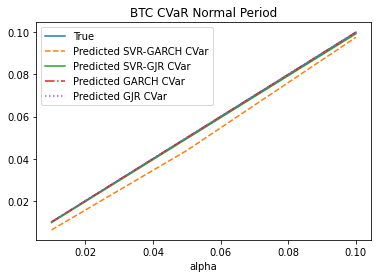

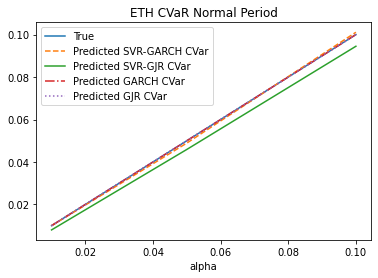

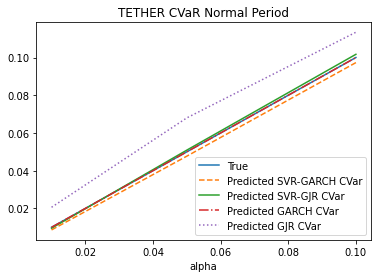

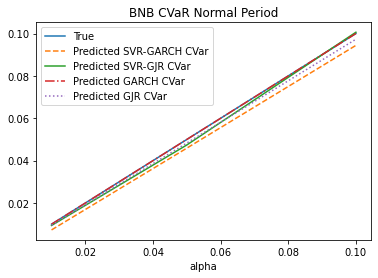

In [ ]:
#CVaR Normal
x = [0.01,0.05,0.1]
y= x
names = ['btc','eth','tether','bnb']
#GARCH
x_cvar_btc_garch_n = np.array([1.0,5.0,10.0])/100
x_cvar_eth_garch_n = np.array([1.0,5.0,10.0])/100
x_cvar_tether_garch_n = np.array([1.0,5.0,10.0])/100
x_cvar_bnb_garch_n = np.array([1.0,5.0,10.0])/100
#GJR
x_cvar_btc_gjr_n = np.array([1,5,10])/100
x_cvar_eth_gjr_n = np.array([1,5,10])/100
x_cvar_tether_gjr_n = np.array([2.06,6.800000000000001,11.34])/100
x_cvar_bnb_gjr_n = np.array([0.95,4.83,9.73])/100

#SVR-GJR
#BTC Normal
x_cvar_btc_svr_gjr_n=np.array([0.97,4.95,9.93])/100
x_cvar_eth_svr_gjr_n = np.array([0.8,4.59,9.45])/100
x_cvar_tether_svr_gjr_n=np.array([0.95,5.09,10.17])/100
x_cvar_bnb_svr_gjr_n=np.array([0.94,4.74,10.06])/100

for name in names:
  x_cvar = [globals()['cvar_%s_n_1' %name],globals()['cvar_%s_n_5' %name],globals()['cvar_%s_n_10' %name]]
  plt.plot(x,y,label='True');
  plt.plot(x,x_cvar,linestyle='--',label='Predicted SVR-GARCH CVar');
  plt.plot(x,globals()['x_cvar_%s_svr_gjr_n' %name],label='Predicted SVR-GJR CVar',linestyle='-')
  plt.plot(x,globals()['x_cvar_%s_garch_n' %name],label='Predicted GARCH CVar',linestyle='dashdot')
  plt.plot(x,globals()['x_cvar_%s_gjr_n' %name],label='Predicted GJR CVar',linestyle=':')
  plt.title(name.upper()+' CVaR Normal Period')
  plt.xlabel('alpha')
  plt.legend();
  plt.show()

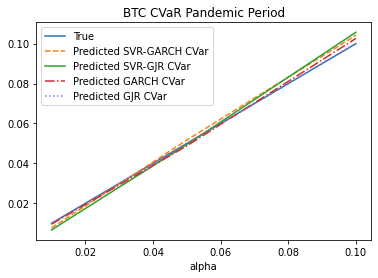

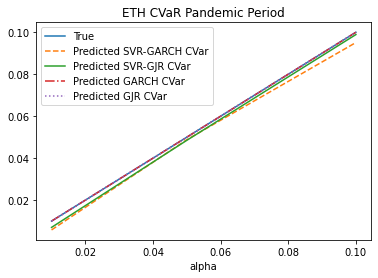

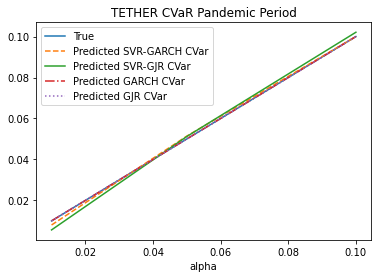

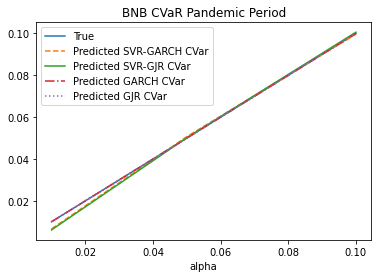

In [ ]:
#CVaR Pandemic
x = [0.01,0.05,0.1]
y= x
names = ['btc','eth','tether','bnb']

#GARCH
x_cvar_btc_garch_p = np.array([0.96,4.88,10.26])/100
x_cvar_eth_garch_p = np.array([1.0,5.0, 10.0])/100
x_cvar_tether_garch_p = np.array([1.0,5.0, 10.0])/100
x_cvar_bnb_garch_p = np.array([1.0,5.0, 10.0])/100
#GJR
x_cvar_btc_gjr_p = np.array([1,5,10])/100
x_cvar_eth_gjr_p = np.array([1,5,10])/100
x_cvar_tether_gjr_p = np.array([1,5,10])/100
x_cvar_bnb_gjr_p = np.array([1,5,10])/100
#SVR-GJR
x_cvar_btc_svr_gjr_p=np.array([0.67,4.95,10.57])/100
x_cvar_eth_svr_gjr_p=np.array([0.7,4.85,9.89])/100
x_cvar_tether_svr_gjr_p=np.array([0.56,5.12,10.21])/100
x_cvar_bnb_svr_gjr_p=np.array([0.61,5.02,10.06])/100 


for name in names:
  x_cvar_btc = [globals()['cvar_%s_p_1' %name],globals()['cvar_%s_p_5' %name],globals()['cvar_%s_p_10' %name]]
  plt.plot(x,y,label='True');
  plt.plot(x,x_cvar_btc,linestyle='--',label='Predicted SVR-GARCH CVar');
  plt.plot(x,globals()['x_cvar_%s_svr_gjr_p' %name],label='Predicted SVR-GJR CVar',linestyle='-')
  plt.plot(x,globals()['x_cvar_%s_garch_p' %name],label='Predicted GARCH CVar',linestyle='dashdot')
  plt.plot(x,globals()['x_cvar_%s_gjr_p' %name],label='Predicted GJR CVar',linestyle=':')
  plt.title(name.upper()+' CVaR Pandemic Period')
  plt.xlabel('alpha')
  plt.legend();
  plt.show()

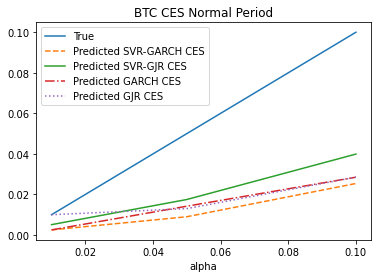

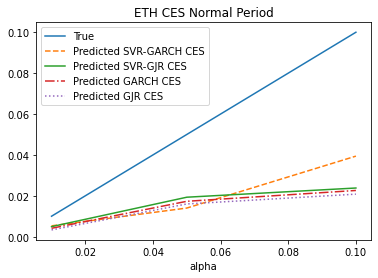

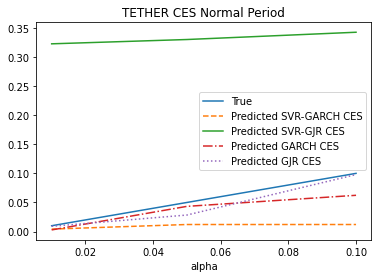

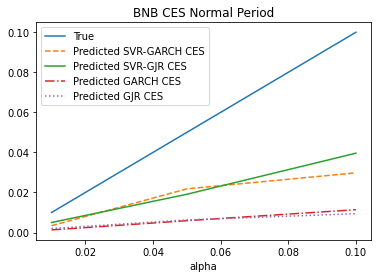

In [ ]:
#CES Normal
x = [0.01,0.05,0.1]
y= x
names = ['btc','eth','tether','bnb']
#GARCH
x_ces_btc_garch_n = np.array([0.25,1.42,2.85])/100
x_ces_eth_garch_n = np.array([0.41,1.73,2.26])/100
x_ces_tether_garch_n = np.array([0.2799999999999,4.33, 6.23])/100
x_ces_bnb_garch_n = np.array([0.13,0.59, 1.14])/100
#GJR
x_ces_btc_gjr_n = np.array([1,1.3,2.85])/100
x_ces_eth_gjr_n = np.array([0.33,1.6,2.08])/100
x_ces_tether_gjr_n = np.array([0.8999999999999999,2.8400000000000003,9.790000000000001])/100
x_ces_bnb_gjr_n = np.array([0.2,0.63,0.94])/100

#SVR-GJR
x_ces_btc_svr_gjr_n=np.array([0.51,1.7500000000000002,3.9899999999999998])/100
x_ces_eth_svr_gjr_n=np.array([0.49,1.9300000000000002, 2.3800000000000003])/100
x_ces_tether_svr_gjr_n=np.array([32.269999999999996,33.01,34.260000000000005])/100
x_ces_bnb_svr_gjr_n=np.array([0.5,1.91,3.96])/100

for name in names:
  x_cvar_btc = [globals()['ces_%s_n_1' %name],globals()['ces_%s_n_5' %name],globals()['ces_%s_n_10' %name]]
  plt.plot(x,y,label='True');
  plt.plot(x,x_cvar_btc,linestyle='--',label='Predicted SVR-GARCH CES');
  plt.plot(x,globals()['x_ces_%s_svr_gjr_n' %name],label='Predicted SVR-GJR CES',linestyle='-')
  plt.plot(x,globals()['x_ces_%s_garch_n' %name],label='Predicted GARCH CES',linestyle='dashdot')
  plt.plot(x,globals()['x_ces_%s_gjr_n' %name],label='Predicted GJR CES',linestyle=':')
  plt.title(name.upper()+' CES Normal Period')
  plt.xlabel('alpha')
  plt.legend();
  plt.show()

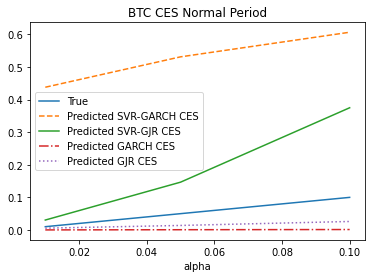

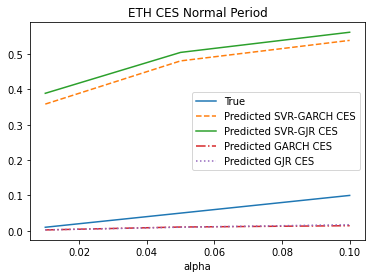

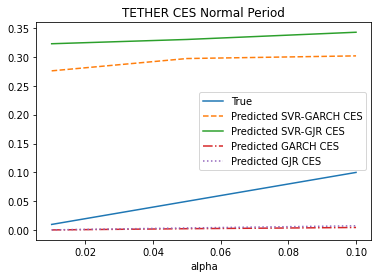

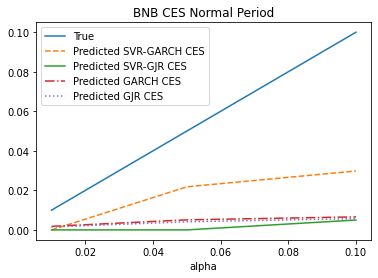

In [ ]:
#CES Pandemic
x = [0.01,0.05,0.1]
y= x
names = ['btc','eth','tether','bnb']
#GARCH
x_ces_btc_garch_p =np.array([0.01,0.06999999999,0.13])/100
x_ces_eth_garch_p = np.array([0.25,1.0699999999, 1.44])/100
x_ces_tether_garch_p = np.array([0.05,0.26, 0.47000000000000003])/100
x_ces_bnb_garch_p = np.array([0.18,0.51, 0.66])/100
#GJR
x_ces_btc_gjr_p = np.array([0.5499999999999999,1.38,2.6])/100
x_ces_eth_gjr_p = np.array([0.26,1.02,1.72])/100
x_ces_tether_gjr_p = np.array([0.06,0.38999999999999996,0.76])/100
x_ces_bnb_gjr_p = np.array([0.15,0.41,0.57])/100

#SVR-GJR
x_ces_btc_svr_gjr_p=np.array([3.04,14.67,37.51])/100
x_ces_eth_svr_gjr_p=np.array([38.87,50.43,56.13])/100
x_ces_tether_svr_gjr_p=np.array([ 32.269999999999996,33.01,34.260000000000005])/100
x_ces_bnb_svr_gjr_p=np.array([0.0,0.0,0.5])/100 

for name in names:
  x_cvar_btc = [globals()['ces_%s_p_1' %name],globals()['ces_%s_p_5' %name],globals()['ces_%s_p_10' %name]]
  plt.plot(x,y,label='True');
  plt.plot(x,x_cvar_btc,linestyle='--',label='Predicted SVR-GARCH CES');
  plt.plot(x,globals()['x_ces_%s_svr_gjr_p' %name],label='Predicted SVR-GJR CES',linestyle='-')
  plt.plot(x,globals()['x_ces_%s_garch_p' %name],label='Predicted GARCH CES',linestyle='dashdot')
  plt.plot(x,globals()['x_ces_%s_gjr_p' %name],label='Predicted GJR CES',linestyle=':')
  plt.title(name.upper()+' CES Normal Period')
  plt.xlabel('alpha')
  plt.legend();
  plt.show()